# House Prices: Advanced Regression Techniques

In this Kernel, I will introduce my submission for this Kaggle competition. In this kernel, I will present my own knowledge and understanding of the Data Science and EDA. More precisely, I will perform the data preprocessing in such way that the data is most suitable for Linear Regression models, which means transforming the data in such way that it displays as much linear dependance to the label as possible. The models used will be simple, and so will the training process, which would make the retraining very simple as well.

The kernel is divided into 3 major parts:

## 1) Data preprocessing: 

This step is the main emphasis of this kernel, and in it, I will perform several of the most common techniques in the data preprocessing:

1) Handling missing data : Will be done using my own *handle_missing_data* function, but I will explain the logic behind the transformations in the kernel

2) Transforming textual to numeric features : Will also be done using my own custom function, but the logic will be explained here

3) Data extraction and data selection : (Correlation matrix, multicolinearity)

4) Dealing with outliers and *normality* of the data : (Logarithmic transformations of the data)

5) Train/validation spit, to *mimic* the test data and get the an accurate approximation of the model performance : (StratifiedKFold)

6) Scalling the data (StandardScaler)

## 2) Training basic linear models:

4 basic Linear Models will be trained:

*LinearRegressor, Ridge, Lasso and ElasticNet* and for each of them, a short explanation of what they "bring to the table will be given"

## 3) Other models:

A couple of "other" models will also be trained. With this step I wanted to check my assumption that the linear models would perform the best on this data, given its preprocessing



First - Import the data and the libraries that will be used

In [1]:
# Some imports and the function for loading the training and the test set

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from scipy import stats
from scipy.stats import norm

from IPython.display import clear_output
import preprocessing_functions
from preprocessing_functions import preprocess
from preprocessing_functions.preprocess import handle_missing_data
from preprocessing_functions.preprocess import text_to_numeric
from preprocessing_functions.preprocess import print_important_info_numeric
from preprocessing_functions.preprocess import print_important_info_object

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

EXTRA_STEPS = "NONE" # Equal to 1 only first time you go through the notebook, to manually do all the preprocessing 

HOUSING_PATH = "dataset/"
TRAIN_HOUSING_NAME = "train.csv"
TEST_HOUSING_NAME = "test.csv"

def load_housing_data(trainset = True):
    housing_path = HOUSING_PATH
    if trainset:
        housing_name = TRAIN_HOUSING_NAME
    else:
        housing_name = TEST_HOUSING_NAME
    csv_path = os.path.join(housing_path, housing_name)
    return pd.read_csv(csv_path)

train_data = load_housing_data()
test_data = load_housing_data(trainset = False)

train_data_cc = train_data.copy()
test_data_cc = test_data.copy()

label = "SalePrice"

print(train_data_cc.info())
print(test_data_cc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

# 1 Data preprocessing

There are features with missing data, so I will print names of all of these features, along with the median of all the prices.

In [2]:
missing_train = train_data_cc.isnull().sum().sort_values(ascending=False)
missing_test = test_data_cc.isnull().sum().sort_values(ascending=False)

missing_train_cats = missing_train[missing_train>0].index.values
missing_test_cats = missing_test[missing_test>0].index.values

missing_all_cats = list(set().union(missing_train_cats, missing_test_cats))
print("Features with missing values :",missing_all_cats)
print("Median of the Prices :", train_data_cc[label].median())

Features with missing values : ['BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'BsmtCond', 'Alley', 'Electrical', 'PoolQC', 'BsmtQual', 'BsmtFinSF1', 'TotalBsmtSF', 'MSZoning', 'BsmtFinType2', 'GarageFinish', 'BsmtFullBath', 'MiscFeature', 'MasVnrType', 'LotFrontage', 'SaleType', 'Exterior1st', 'Fence', 'GarageCond', 'Functional', 'MasVnrArea', 'BsmtFinSF2', 'GarageQual', 'KitchenQual', 'FireplaceQu', 'GarageType', 'Utilities', 'Exterior2nd', 'BsmtFinType1', 'GarageCars', 'BsmtHalfBath', 'BsmtExposure']
Median of the Prices : 163000.0


## 1.1 Handling missing data

Now I start the process of handling the features with the missing values using the preprocess function called "handle_missing_data", where I encounter several typical cases dealt with in a similar way:

1) Filling the data with the median, most_frequent or special "custom" value given by the programmer

2) Dropping the feature where it makes sense

All of the cases encountered are explained below:

### Case 1:

Filling the data with the median or the most frequent value:

In cases in which the number of missing data is small, and there can be no assumption made on what the meaning of the missing values is.

It was done in the cases of the features:

Exterior1st, Exterior2nd, SaleType, KitchenQual, MSZoning

Below is the the example of the KitchenQual feature.

Number of missing training data values -  0
Percentage of missing training data values -  0.0 %

Number of missing test data values -  1
Percentage of missing test data values -  0.06854009595613435 %


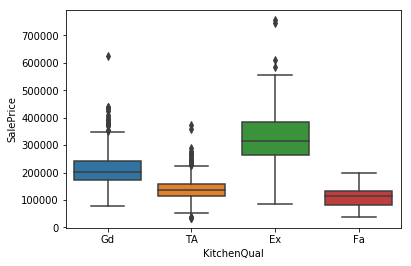

             SalePrice
KitchenQual           
Ex              316750
Gd              201400
TA              137000
Fa              115000
Values inside the training set for KitchenQual feature:
TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64
Values inside the test set for KitchenQual feature:
TA    757
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64


In [3]:
cat = "KitchenQual"
print("Number of missing training data values - ", train_data_cc[cat].isnull().sum())
print("Percentage of missing training data values - ", train_data_cc[cat].isnull().sum()/train_data_cc[cat].isnull().count()*100, "%")
print("\nNumber of missing test data values - ", test_data_cc[cat].isnull().sum())
print("Percentage of missing test data values - ", test_data_cc[cat].isnull().sum()/test_data_cc[cat].isnull().count()*100, "%")
print_important_info_object(train_data_cc, test_data_cc, cat, label)

### Case 2:

Filling in the missing data with the value of 0:

Data with a small number of missing data, but where instead of imputing the feature with the median value, it makes more sense to impute it with the value of 0, as the missing data most probably means the absense of that feature, and as the features are numeric => I imputed them with 0

Features imuted that way:

TotalBsmtSF, BsmtUnfSF, GarageArea, BsmtFinSF1, BsmtFinSF2, BsmtHalfBath, BsmtFullBath, MasVnrArea, GarageCars

Special case is the LotFrontage, that does have a big number of missing data, but it was observed that none of the present data has the value of 0, so I assumed that the missing data means 0 => no connection to the street

Below is the example of the TotalBsmtSF

Number of missing training data values -  0
Percentage of missing training data values -  0.0 %

Number of missing test data values -  1
Percentage of missing test data values -  0.06854009595613435 %


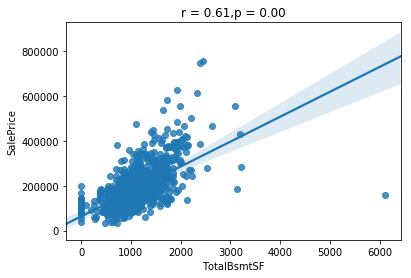

In [4]:
cat = "TotalBsmtSF"
print("Number of missing training data values - ", train_data_cc[cat].isnull().sum())
print("Percentage of missing training data values - ", train_data_cc[cat].isnull().sum()/train_data_cc[cat].isnull().count()*100, "%")
print("\nNumber of missing test data values - ", test_data_cc[cat].isnull().sum())
print("Percentage of missing test data values - ", test_data_cc[cat].isnull().sum()/test_data_cc[cat].isnull().count()*100, "%")
print_important_info_numeric(train_data_cc, cat, label)

### Case 3:

Imputing the missing data with the "None" value:

For some of the features it is explicitly mentioned in the data description that the missing value means the absence of that feature (No garage, no basement,...), or it seems like the most logical explanation (MasVnrType), so I impute those datapoints with the "None" value

Features imputed that way :

BsmtFinType1, MasVnrType, GarageFinish, BsmtFinType2, BsmtQual, BsmtCond, BsmtExposure, FireplaceQu, 
GarageType, Fence

Below is the example of the BsmtQual feature:

Number of missing training data values -  37
Percentage of missing training data values -  2.5342465753424657 %

Number of missing test data values -  44
Percentage of missing test data values -  3.015764222069911 %


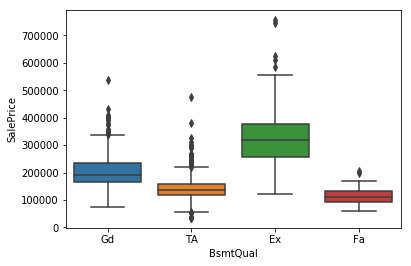

          SalePrice
BsmtQual           
Ex           318000
Gd           192070
TA           135500
Fa           112000
Values inside the training set for BsmtQual feature:
TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
Values inside the test set for BsmtQual feature:
TA    634
Gd    591
Ex    137
Fa     53
Name: BsmtQual, dtype: int64


In [5]:
cat = "BsmtQual"
print("Number of missing training data values - ", train_data_cc[cat].isnull().sum())
print("Percentage of missing training data values - ", train_data_cc[cat].isnull().sum()/train_data_cc[cat].isnull().count()*100, "%")
print("\nNumber of missing test data values - ", test_data_cc[cat].isnull().sum())
print("Percentage of missing test data values - ", test_data_cc[cat].isnull().sum()/test_data_cc[cat].isnull().count()*100, "%")
print_important_info_object(train_data_cc, test_data_cc, cat, label)

### Case 4:

Dropping the feature from the dataset:

This is done if one of the 2 cases occur:

1) There is too much missing data, and no comclusion on the meaning of the missing data can be done

2) The feature has one domimnant value, and most of the instances take that value

Features being dropped because of one of the 2 reasons are:

Utilities, GarageQual, Functional, PoolQC, Alley, GarageCond, MiscFeature

Special case happened in the the Electrical feature, where even though SBrkr was the dominant value, I noticed that the average price for the houses that had that value was much higher than in the case of other values. I imputed the Electrical feature as the Case 1.

Below is the example of the PoolQC feature

Number of missing training data values -  1453
Percentage of missing training data values -  99.52054794520548 %

Number of missing test data values -  1456
Percentage of missing test data values -  99.7943797121316 %


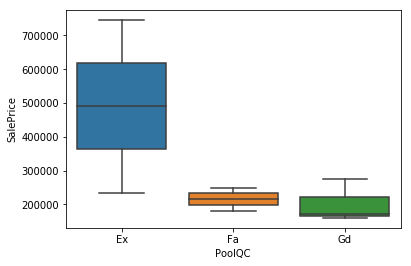

        SalePrice
PoolQC           
Ex         490000
Fa         215500
Gd         171000
Values inside the training set for PoolQC feature:
Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64
Values inside the test set for PoolQC feature:
Ex    2
Gd    1
Name: PoolQC, dtype: int64


In [6]:
cat = "PoolQC"
print("Number of missing training data values - ", train_data_cc[cat].isnull().sum())
print("Percentage of missing training data values - ", train_data_cc[cat].isnull().sum()/train_data_cc[cat].isnull().count()*100, "%")
print("\nNumber of missing test data values - ", test_data_cc[cat].isnull().sum())
print("Percentage of missing test data values - ", test_data_cc[cat].isnull().sum()/test_data_cc[cat].isnull().count()*100, "%")
print_important_info_object(train_data_cc, test_data_cc, cat, label)

Below, I called and executed the handle_missing_data helper gfunction, doing the process that was described above.
As the output of the function is very long, it wont be printed here, but there is a file "handle_missing_data" where it is explained how each feature is treated.

The function also allows the object (textual) data to be converted to numeric data immediately, but in order to make the preprocessing more structured, I will only handle the missing data at this moment

In [7]:
if EXTRA_STEPS == "HANDLE_MISSING":
    train_data_cc, test_data_cc = handle_missing_data(train_data_cc, test_data_cc, label, mode = "auto", logfile = "functions_log/handle_missing_data.txt")

In [8]:
if EXTRA_STEPS == "HANDLE_MISSING":    
    train_data_cc.to_csv("data_stages/train_stage1_nomissing_interim.csv", index = False)
    test_data_cc.to_csv("data_stages/test_stage1_nomissing_interim.csv", index = False)

In [9]:
train_data_cc = pd.read_csv("data_stages/train_stage1_nomissing_interim.csv")
test_data_cc = pd.read_csv("data_stages/test_stage1_nomissing_interim.csv")

In [10]:
missing_train = train_data_cc.isnull().sum().sort_values(ascending=False)
missing_test = test_data_cc.isnull().sum().sort_values(ascending=False)

missing_train_cats = missing_train[missing_train>0].index.values
missing_test_cats = missing_test[missing_test>0].index.values

missing_all_cats = list(set().union(missing_train_cats, missing_test_cats))
print("Features with missing values :",missing_all_cats)

Features with missing values : ['GarageYrBlt']


GarageYrBlt was skipped during the handling process, as it is considered a special case. Even though it seems like an interesting feature, I assume that the Year th garage is built is the same as the Year the whole house was built. I will test the hypothesis, and if it is correct, I will drop the feature!

In [11]:
print("Where Garage Year equals the Year Bulit, for the training set:",len(train_data_cc[train_data_cc["GarageYrBlt"] == train_data_cc["YearBuilt"]]))
print("Where Garage Year equals the Year Bulit, for the test set:",len(test_data_cc[test_data_cc["GarageYrBlt"] == test_data_cc["YearBuilt"]]))

Where Garage Year equals the Year Bulit, for the training set: 1089
Where Garage Year equals the Year Bulit, for the test set: 1127


Hypothesis is correct, so i am dropping the feature!

In [12]:
train_data_cc.drop(["GarageYrBlt"], axis = 1, inplace = True)
test_data_cc.drop(["GarageYrBlt"], axis = 1, inplace = True)

Making sure one more time that there are no features with missing values:

In [13]:
missing_train = train_data_cc.isnull().sum().sort_values(ascending=False)
missing_test = test_data_cc.isnull().sum().sort_values(ascending=False)

missing_train_cats = missing_train[missing_train>0].index.values
missing_test_cats = missing_test[missing_test>0].index.values

missing_all_cats = list(set().union(missing_train_cats, missing_test_cats))
print("Features with missing values :",missing_all_cats)

Features with missing values : []


And saving the data, so that i dont have to go through the same process again!

In [14]:
train_data_cc.to_csv("data_stages/train_stage1_nomissing.csv", index = False)
test_data_cc.to_csv("data_stages/test_stage1_nomissing.csv", index = False)

In [15]:
train_data_cc = pd.read_csv("data_stages/train_stage1_nomissing.csv")
test_data_cc = pd.read_csv("data_stages/test_stage1_nomissing.csv")

## 1.2 Transforming textual to numeric features

Now that there is no missing data, I will convert the textual features into numeric features:

In [16]:
text_cats = list(train_data_cc.select_dtypes(include = "object").columns)
print("Number of the textual features:", len(text_cats))
print("Features with textual data:", text_cats)

Number of the textual features: 37
Features with textual data: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']


Now I handle the textual features. In order to make the data all of the models that scikit-learn has to offer, I transform all the textual features into numeric features. 

### Case1 
A lot of the features have values that, even though are textual, actually give values that can be easy to transform into a numeric feature. For example, features like GarageQual, KitchenQual, ExterQual are ordinal features, where the lowest value (Poor or None) can be transformed into the lowest given value (usually 1), and the higher the quality, the higher a number is given.

Features treated this way are : ExterQual, BsmtQual, BsmtCond, BsmtExposure, HeatingQC, KitchenQual, FireplaceQu, GarageQual

Below is the example of the ExterQual:


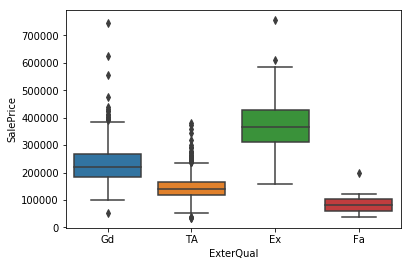

           SalePrice
ExterQual           
Ex          364606.5
Gd          220000.0
TA          139450.0
Fa           82250.0
Values inside the training set for ExterQual feature:
TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64
Values inside the test set for ExterQual feature:
TA    892
Gd    491
Ex     55
Fa     21
Name: ExterQual, dtype: int64


In [17]:
print_important_info_object(train_data_cc, test_data_cc, "ExterQual", label)

As can be seen Fa < TA < Gd < Ex, so the new features has value 1 for those instances where ExterQual has Fa, value 2 for TA, and so on...


### Case 2 
Next example are the features that, even though they are not ordinal, could be transformed into an ordinal feature by grouping the values using some assumptions, and then giving them numeric values. One such example could be the MSZoning feature:

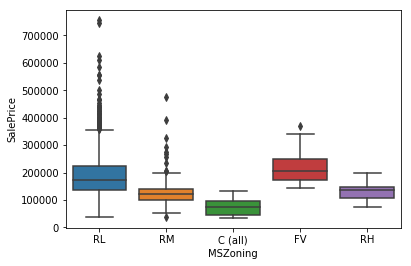

          SalePrice
MSZoning           
FV           205950
RL           174000
RH           136500
RM           120500
C (all)       74700
Values inside the training set for MSZoning feature:
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Values inside the test set for MSZoning feature:
RL         1118
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64


In [18]:
print_important_info_object(train_data_cc, test_data_cc, "MSZoning", label)

Using common sense, I can use the assumption that Residential Zones have higher prices, and the lower the density, the higher the price. Lastly, Floating villages should have even higher prices than the regular residential zones, so I use the assumption:

C < RH < RM < RL < FV

Once I have transformed the data using this assumption, I can plot the newly created feature and see whether the assumption holds. If not, I can drop the feature.

Features that were treated in tha way are : MSZoning, GarageFin, MasVnrType, SaleType, CentralAir

### Case 3 
There are also some features where no assumption on the numeric values of the categorical values can be made. In that case, I can observe the distribution of the data and cluster them, with respect to the prices of the houses that have that exact value for the feature. Then, I create a feature where those instances that have a value belonging to a cluster that has high values for the housing prices, have high values for the feature, and vice-versa. One example of such a feature is the Foundation feature:

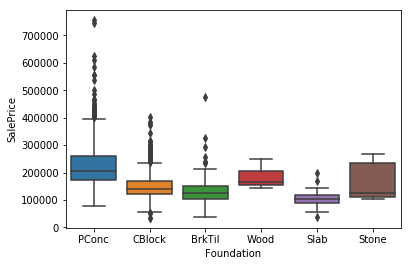

            SalePrice
Foundation           
PConc          205000
Wood           164000
CBlock         141500
Stone          126500
BrkTil         125250
Slab           104150
Values inside the training set for Foundation feature:
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64
Values inside the test set for Foundation feature:
PConc     661
CBlock    601
BrkTil    165
Slab       25
Stone       5
Wood        2
Name: Foundation, dtype: int64


In [19]:
print_important_info_object(train_data_cc, test_data_cc, "Foundation", label)

As can be seen, those houses that have the PConc as the value for the feature have significantly higher average prices than the rest. As the PConc is also present in a significant number of instances, I can assume that it is not an error and that it is an information of interest. Therefore, I make a new numeric feature where instances with the value PConc ave value 2, while all the other instances have value 1.

Another good example is the Neighborhood, although it is more complicated:

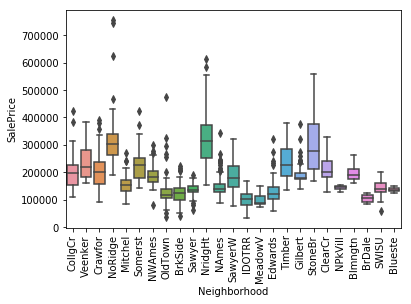

                  SalePrice
Neighborhood               
NoRidge       335295.317073
NridgHt       316270.623377
StoneBr       310499.000000
Timber        242247.447368
Veenker       238772.727273
Somerst       225379.837209
ClearCr       212565.428571
Crawfor       210624.725490
CollgCr       197965.773333
Blmngtn       194870.882353
Gilbert       192854.506329
NWAmes        189050.068493
SawyerW       186555.796610
Mitchel       156270.122449
NAmes         145847.080000
NPkVill       142694.444444
SWISU         142591.360000
Blueste       137500.000000
Sawyer        136793.135135
OldTown       128225.300885
Edwards       128219.700000
BrkSide       124834.051724
BrDale        104493.750000
IDOTRR        100123.783784
MeadowV        98576.470588
Values inside the training set for Neighborhood feature:
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel

In [20]:
category = "Neighborhood"

sns.boxplot(x=category, y=label, data=train_data_cc)
plt.xticks(rotation=90)
plt.show()    
pivot = train_data.pivot_table(index=category, values=label, aggfunc=np.mean)
print(pivot.sort_values(label,axis=0,ascending=False))
print("Values inside the training set for", category, "feature:")
print(train_data_cc[category].value_counts())
print("Values inside the test set for", category, "feature:")
print(test_data_cc[category].value_counts())

In this case, I clustered the data into 7 clusters, based on the average price of the houses in that neighborhood. In order to make sure that the data is not flawed, I would cluster them into clusters that are represented by a suffcient number of instances in the training set (sum of number of instances having each of the individual values shouldnt be too small). The clustering i performed is (values in the origianl training set : new values):

BrDale,IDOTRR,MeadowV : 1

OldTown,Edwards,BrkSide : 2

NPkVill,NAmes,SWISU,Blueste,Sawyer,Mitchel : 3

SawyerW,Gilbert,NWAmes : 4

Crawfor,ClearCr,CollgCr,Blmngtn : 5

Timber,Somerst,Veenker : 6

NridgHt,NoRidge,StoneBr : 7


Features treated using the same logic as Neighborhood and  Foundation are : LotShape, GarageType, Fence, SaleCondition, Electrical, RoofStyle, Exterior1st, Exterior2nd

### Case 4 
Fourth case are the features that were dropped due to the fact that there is very little variance in the data, aka most of the instances have 1 value, so the feature cannot be useful. 

Such features are : Street, LandContour, LandSlope, RoofMatl, Heating

Below is the example of the Street feature:

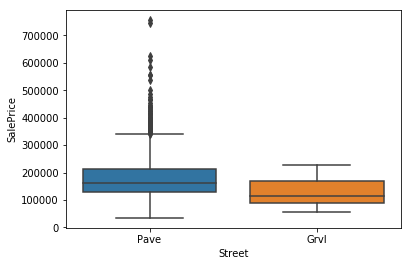

        SalePrice
Street           
Pave       163000
Grvl       114250
Values inside the training set for Street feature:
Pave    1454
Grvl       6
Name: Street, dtype: int64
Values inside the test set for Street feature:
Pave    1453
Grvl       6
Name: Street, dtype: int64


In [21]:
print_important_info_object(train_data_cc, test_data_cc, "Street", label)

Only 6 instances in both the training and the test set have the Grvl value, so the feature is not good, and is hence dropped

### Case 5 
Some features are dropped because because they cannot be transformed into numeric features, and using the get_dummies binarization would create a lot of new features that would not be of much use. 

Such features are : LotConfig, Condition1, Condition2, BldgType

Below is the example of the LotConfig feature:

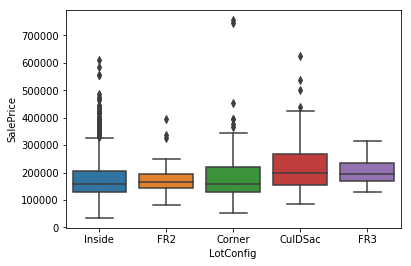

           SalePrice
LotConfig           
CulDSac     199262.0
FR3         195450.0
FR2         165000.0
Corner      160000.0
Inside      159697.5
Values inside the training set for LotConfig feature:
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Values inside the test set for LotConfig feature:
Inside     1081
Corner      248
CulDSac      82
FR2          38
FR3          10
Name: LotConfig, dtype: int64


In [22]:
print_important_info_object(train_data_cc, test_data_cc, "LotConfig", label)

It might make sense to cluster the data so that the CulDSac and FR3 have higher value (2) then the rest of the data (1), but that would create a feature where only 100 instances have the value 2, and after all, since FR3 is only represented by 4 instances in the training set, it is dificult to know whether the difference in the average price is just an error

### Case 6 
Last example is the example of ExterCond feature:

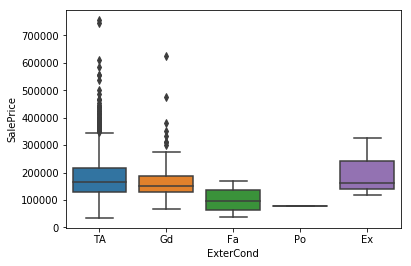

           SalePrice
ExterCond           
TA            167370
Ex            161000
Gd            151250
Fa             95750
Po             76500
Values inside the training set for ExterCond feature:
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64
Values inside the test set for ExterCond feature:
TA    1256
Gd     153
Fa      39
Ex       9
Po       2
Name: ExterCond, dtype: int64


In [23]:
print_important_info_object(train_data_cc, test_data_cc, "ExterCond", label)

Even though the feature is has ordinal value, huge majority of instances have value TA (typical), close to the average price of the whole set, while Gd and Ex have average price values lower than in the case of TA. The feature is therefore dropped, as it doesn't adhere to the logic that better condition makes for a bigger price.


Below, I called the function that is explained in anoter kernel, and transformed all the features following these 6 rules.

In [24]:
if EXTRA_STEPS == "HANDLE_TEXTUAL":
    train_data_cc, test_data_cc = text_to_numeric(train_data_cc, test_data_cc, label, mode = "auto", logfile = "functions_log/handle_textual_data.txt")

In [25]:
if EXTRA_STEPS == "HANDLE_TEXTUAL":    
    train_data_cc.to_csv("data_stages/train_stage1_notextual_interim.csv", index = False)
    test_data_cc.to_csv("data_stages/test_stage1_notextual_interim.csv", index = False)
    EXTRA_STEPS = "NONE"

In [26]:
train_data_cc = pd.read_csv("data_stages/train_stage1_notextual_interim.csv")
test_data_cc = pd.read_csv("data_stages/test_stage1_notextual_interim.csv")

## 1.3 Feature extraction and feature selection

To start, I will check the features correlation to the target.

In order to do that, I will plot the correlation matrix. As the data consists of a big number of features, I will save the matrix into a .png file, and then check for the correlations there

In [27]:
def plot_corr_matrix(df, targ, name = "corr_matrix.png") :
    
    corr = df.corr()
    corr_abs = corr.abs()
    corr_abs = corr_abs[targ].sort_values(ascending=False)
    cols = corr_abs.index
    cm = np.corrcoef(df[cols].values.T)
    fig = plt.figure(figsize=(50,50))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    #plt.show()
    plt.savefig(name)
    #plt.close()


In [28]:
#plot_corr_matrix(train_data_cc, label, "corr_matrix_begining.png")

There are quite a few of the features providing really useful information about the price, like the OverallQual (information on the overall quality of the housing), GrLivArea (Total living area of the housing), NeighborhoodBin, and the individual qualities of the most common housing parts (Kitchen, External, Basement, etc...). It is expected, and these features will surely provide useful information.

However, it can be noted that GarageCars and GarageArea show high level of multicolinearity (even though features should be independent, these 2 show a lot of dependancy, which is expected as the number of cars in a garage is limited by the area). In such a case, it would make sense to drop one of the features (the one with a smaller correlation to the price), or combine them into 1 feature and, if such a feature provides even more correlation to the price, keep the new feature and drop the 2 original features. Apart from these 2, there is a number of features showing the same behavior. They will be treated in the steps 2 and 3.

For now, I pay the most attention to the "weakest" features (showing the lowest levels of correlation to the price). Before discarding them, it makes sense to plot them and see whether they could provide interesting information and maybe be used in the creation of a new feature.

Printing the correlation values and the scatter plot for the 5 weakest features

LowQualFinSF    0.025606
Id              0.021917
MiscVal         0.021190
BsmtHalfBath    0.016844
BsmtFinSF2      0.011378
Name: SalePrice, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a12392cf8>,
      dtype=object)

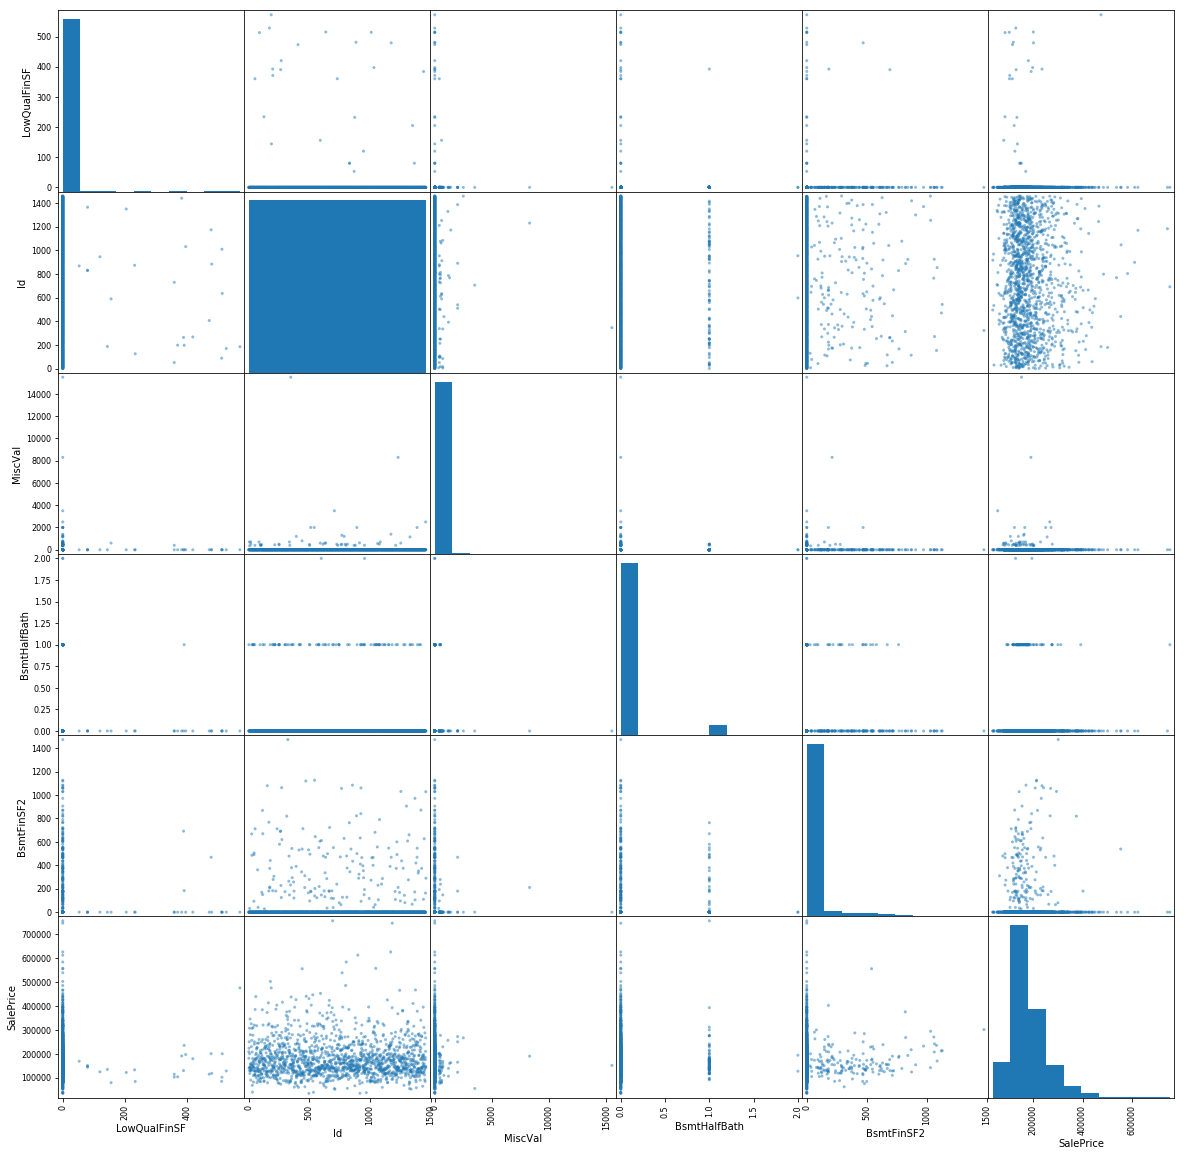

In [29]:
from pandas.tools.plotting import scatter_matrix
corr = train_data_cc.corr()
corr_abs = corr.abs()
corr_abs = corr_abs[label].sort_values(ascending=False)
print(corr_abs[-5:])
low_correlated_features = list(corr_abs[-5:].index)
low_correlated_features.append(label)
attributes = low_correlated_features
scatter_matrix(train_data_cc[attributes], figsize=(20,20))

LowQualFinSF - Seems like a very bad feature, most of its value is 0, and no correlation seem to exist there.

Id - Surely redundant, if the data is well shuffled, than the ID of the housing should not have any effect on the price. The Id column of the test set will be saved as it is needed for the submission file.

MiscVal - Seems bad as well, but maybe it can be used in some way, so I keep it for now.

BsmtHalfBath - Maybe could be used in combination with some other Bath or Basement data, so I keep it.

BsmtFinSF2 - Same as the one above.

Conclusion - drop LowQualFinSF and Id

In [30]:
test_ids = test_data_cc["Id"].copy() # Needs to be kept for later
train_data_cc.drop(["LowQualFinSF","Id"], axis = 1, inplace = True)
test_data_cc.drop(["LowQualFinSF","Id"], axis = 1, inplace = True)

Doing the same process for the next 5 weak features:

MSSubClass     0.084284
OverallCond    0.077856
MoSold         0.046432
3SsnPorch      0.044584
YrSold         0.028923
Name: SalePrice, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59ec8ba400>,
      dtype=object)

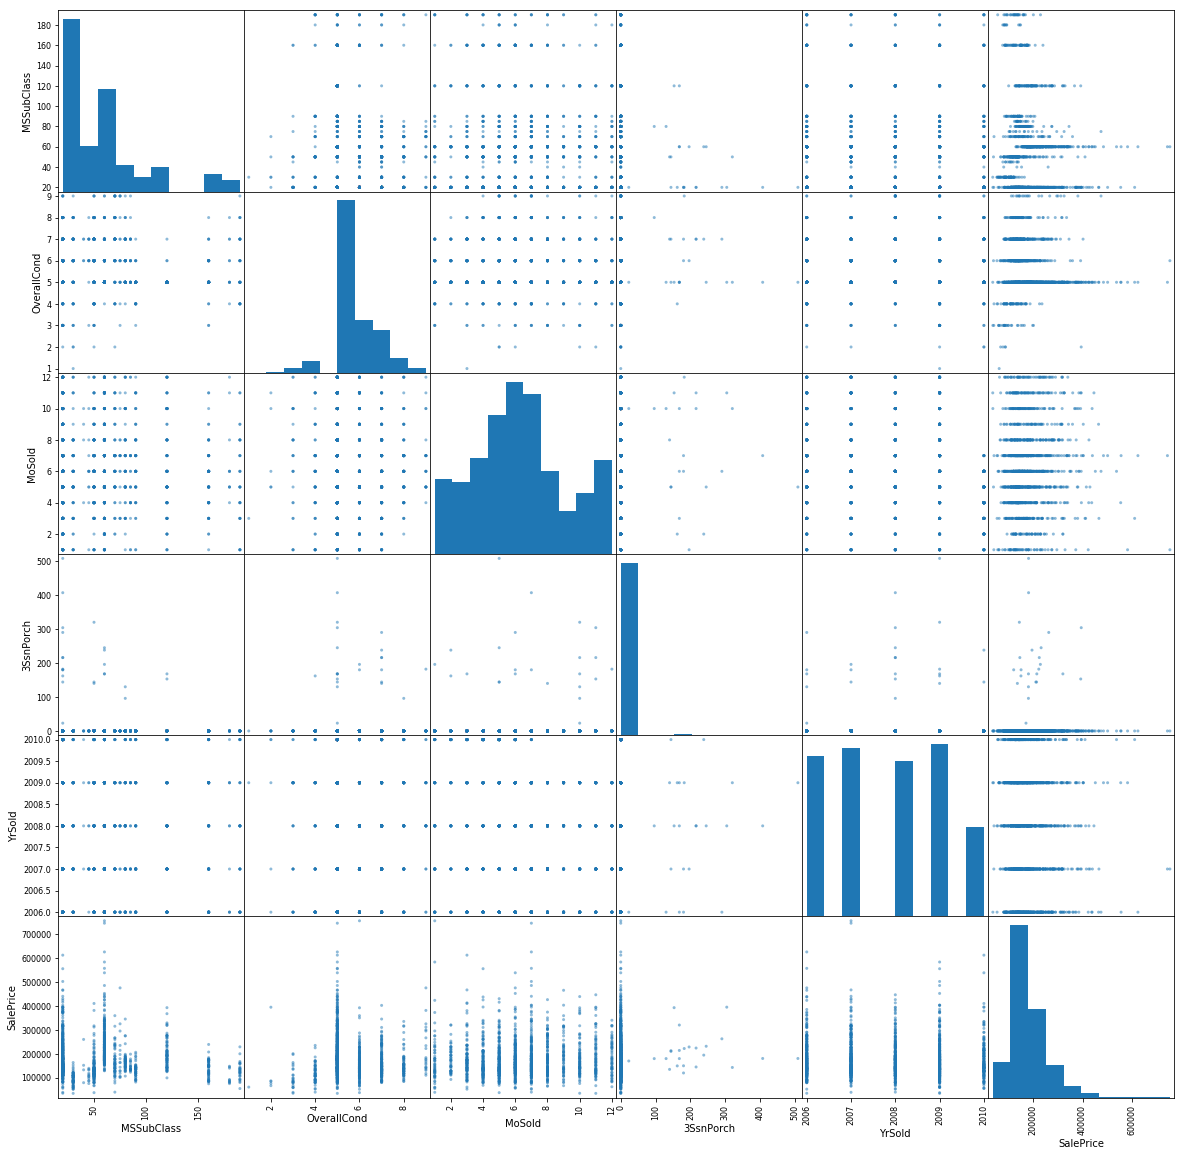

In [31]:
print(corr_abs[-10:-5])
low_correlated_features = list(corr_abs[-10:-5].index)
low_correlated_features.append(label)
attributes = low_correlated_features
scatter_matrix(train_data_cc[attributes], figsize=(20,20))

A lot of data is actually categorical, so maybe that can be used to make better features.

MSSubClass could be used, but its values need to be changed, or clustered.

The same will could maybe be done for the OverallCond and MoSold

Porch could be kept, as it might be combined with the other Porch features.

YrSold might be interesting if the values of years are different in the training and the test set. If YrSold for the test set are all after 2010, then it would make sense to use the 2010 as the validation prices, as the prices might follow some time trend. If not, it might make sense to make a feature of HowOld to indicate how old a house was when it was sold, as that feature could provide more information than just the Year of build.

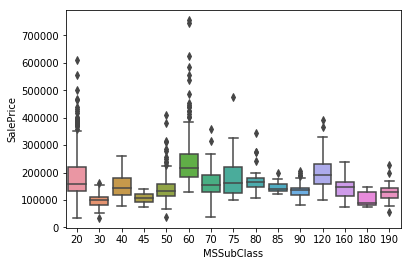

            SalePrice
MSSubClass           
60             215200
120            192000
80             166500
75             163500
20             159250
70             156000
160            146000
40             142500
85             140750
90             135980
50             132000
190            128250
45             107500
30              99900
180             88500
Values inside the training set for MSSubClass feature:
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
Values inside the test set for MSSubClass feature:
20     543
60     276
50     143
120     95
30      70
70      68
160     65
80      60
90      57
190     31
85      28
180      7
75       7
45       6
40       2
150      1
Name: MSSubClass, dtype: int64


In [32]:
#train_data_cc, test_data_cc = text_to_numeric(train_data_cc, test_data_cc, label, mode = "list", categories = ["MSSubClass"])
print_important_info_object(train_data_cc, test_data_cc, "MSSubClass", label)

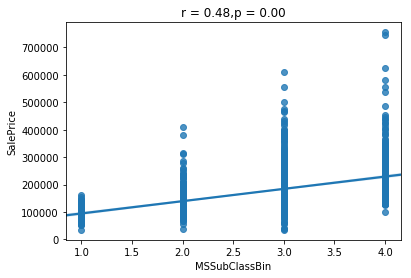

In [33]:
train_data_cc["MSSubClassBin"] = 1
test_data_cc["MSSubClassBin"] = 1
train_data_cc.loc[(train_data_cc["MSSubClass"].isin([160,40,85,90,50,190])), "MSSubClassBin"] = 2
test_data_cc.loc[(test_data_cc["MSSubClass"].isin([160,40,85,90,50,190])), "MSSubClassBin"] = 2
train_data_cc.loc[(train_data_cc["MSSubClass"].isin([80,75,20,70,150])), "MSSubClassBin"] = 3
test_data_cc.loc[(test_data_cc["MSSubClass"].isin([80,75,20,70,150])), "MSSubClassBin"] = 3
train_data_cc.loc[(train_data_cc["MSSubClass"].isin([60,120])), "MSSubClassBin"] = 4
test_data_cc.loc[(test_data_cc["MSSubClass"].isin([60,120])), "MSSubClassBin"] = 4

print_important_info_numeric(train_data_cc, "MSSubClassBin", label)

train_data_cc.drop(["MSSubClass"], axis = 1, inplace = True)
test_data_cc.drop(["MSSubClass"], axis = 1, inplace = True)

In [34]:
print(train_data_cc["MSSubClassBin"].value_counts())
print(test_data_cc["MSSubClassBin"].value_counts())

3    670
4    386
2    313
1     91
Name: MSSubClassBin, dtype: int64
3    679
4    371
2    326
1     83
Name: MSSubClassBin, dtype: int64


Here, an example of the conversion to a numeric feature process was shown. Based on the median housing price for each of the original values, I clustered the data into 4 clusters, making sure that all of the new data is represented by a non-insignificant number of instances in the training set, so that the new featues is valid. If I made a special cluster that was only supported by a couple of instances in the training set, it would likely be an error, as assuming some relation only based on a coule of instances could lead to wrong assumptions.

I will now print the important information of the OverallCond and MoSold features to see whether they can be trasnformed into new, better features.

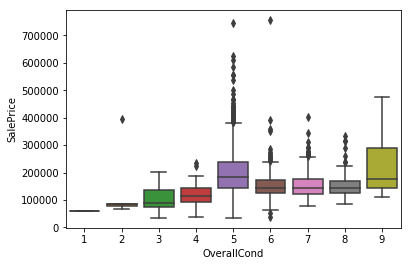

             SalePrice
OverallCond           
5               185000
9               176200
7               145000
6               142750
8               142500
4               115000
3                89500
2                85000
1                61000
Values inside the training set for OverallCond feature:
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64
Values inside the test set for OverallCond feature:
5    824
6    279
7    185
8     72
4     44
3     25
9     19
1      6
2      5
Name: OverallCond, dtype: int64


In [35]:
print_important_info_object(train_data_cc, test_data_cc, "OverallCond", label)

For some reason, the overall condition of the housing with the value of 5 leads to housing prices that are significantly higher than the average housing price, and also significantly higher than the housing prices for the houses that have the overall condition of 6 or 7. Maybe the agents that gave the housing a value higher than 5 are lying and trying to exaggerate the price? 

Even though Linear regression model might not be able to capture a lot of use of this feature, some models like the tree-based models could, so I will keep the feature as it is, hoping that the model would find some hidden connection that I cannot see.

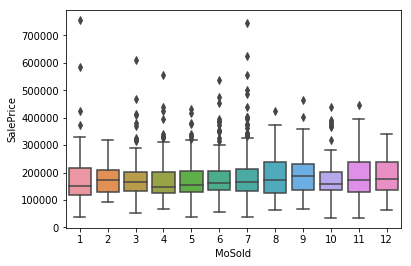

        SalePrice
MoSold           
9          185900
12         178000
8          174450
2          173250
11         173000
3          165250
7          165195
6          163000
10         159000
5          154000
1          151650
4          147000
Values inside the training set for MoSold feature:
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64
Values inside the test set for MoSold feature:
6     250
7     212
5     190
4     138
3     126
8     111
9      95
10     84
2      81
1      64
11     63
12     45
Name: MoSold, dtype: int64


In [36]:
print_important_info_object(train_data_cc, test_data_cc, "MoSold", label)

The only information that can be extracted from this feature is that the majority of the housings are sold in the spring-summer period of the year, I assume due to the better weather. When it comes to the effect of the months on the price, even though it would seem like the prices are higher during the months of September or December, such a claim is not supported by a big number of instances (63 and 59, respectively), so it might be a statistical error. Also, none of the months has the median housing price that deviates substantially from the median housing price, so it would be the best to just get rid of the feature.

In [37]:
train_data_cc.drop(["MoSold"], axis = 1, inplace = True)
test_data_cc.drop(["MoSold"], axis = 1, inplace = True)

Next is the YrSold feature:

In [38]:
print(train_data_cc["YrSold"].value_counts())
print(test_data_cc["YrSold"].value_counts())

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64
2007    363
2008    318
2009    309
2006    305
2010    164
Name: YrSold, dtype: int64


As the value distribution is fairly similar for both the training and the test set, the assumption that maybe all of the houses in the training set were sold earlier or after the ones in the training set, is not valid. Therefore, the only thing that is left to be done is to make a new feature, indicating how old the house was in the moment of being sold, hoping that such a feature would make a slightly better predictor than the regular YearBuilt feature

In [39]:
train_data_cc["HowOld"] = 1 + train_data_cc["YrSold"] - train_data_cc["YearBuilt"]
test_data_cc["HowOld"] = 1 + test_data_cc["YrSold"] - test_data_cc["YearBuilt"]

train_data_cc.drop(["YrSold"], axis = 1, inplace = True)
test_data_cc.drop(["YrSold"], axis = 1, inplace = True)

Next 5 features:

BsmtFinType2Bin    0.154042
KitchenAbvGr       0.135907
EnclosedPorch      0.128578
ScreenPorch        0.111447
PoolArea           0.092404
Name: SalePrice, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59eaa47668>,
      dtype=object)

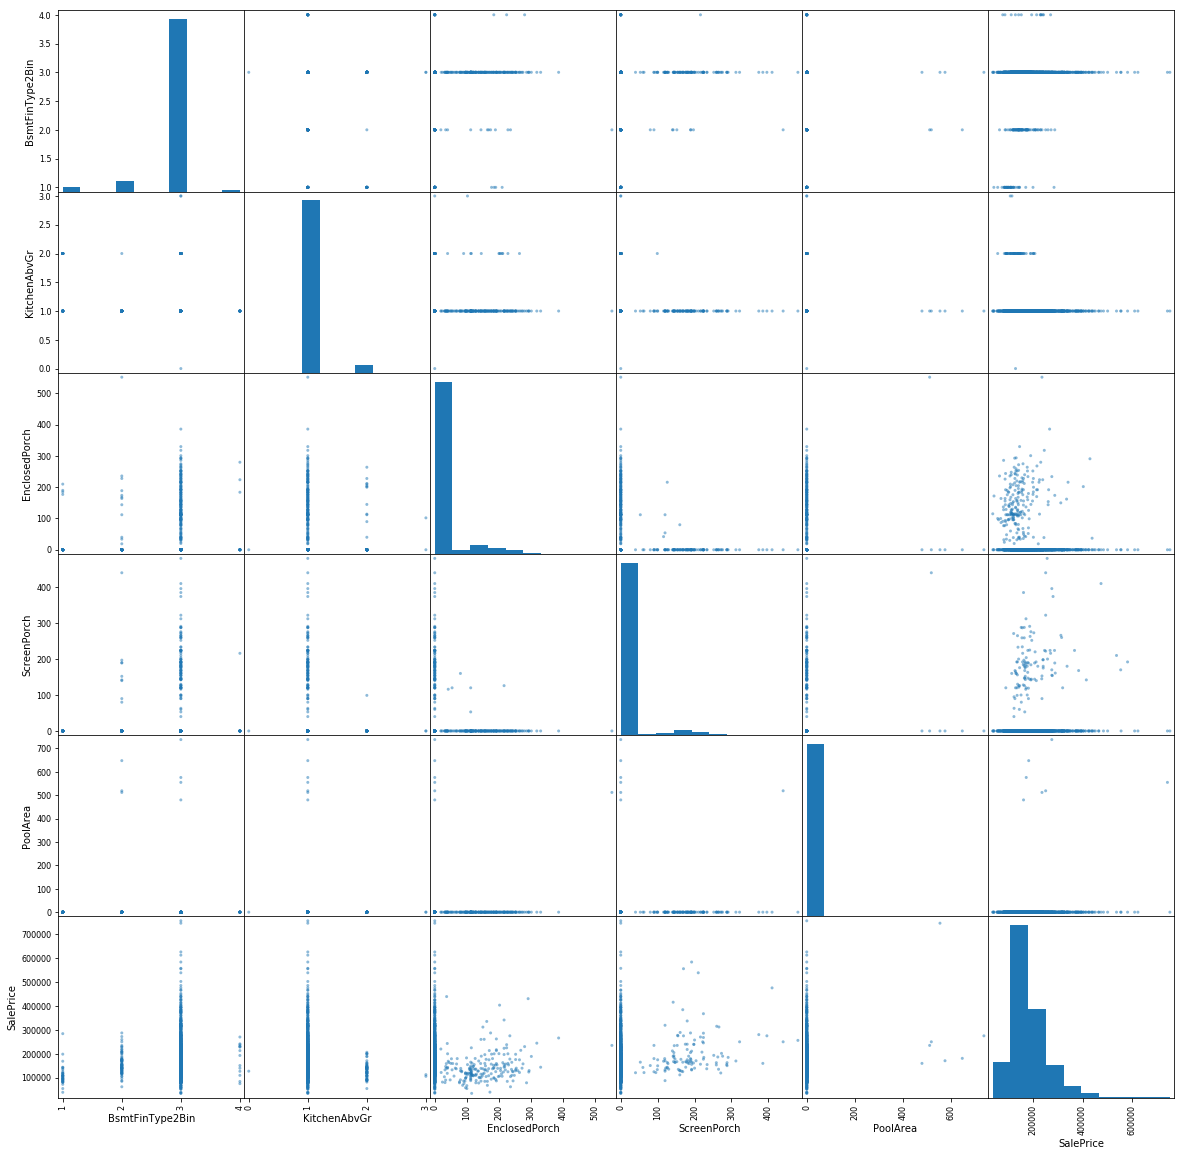

In [40]:
print(corr_abs[-15:-10])
low_correlated_features = list(corr_abs[-15:-10].index)
low_correlated_features.append(label)
attributes = low_correlated_features
scatter_matrix(train_data_cc[attributes], figsize=(20,20))

Even though these features by themselves are not very correlated to the target, maybe they could be used together with some other features (Basement features, Kitchen features, or other Porches area), to make more useful features.

PoolArea, however has only a few instances where the value is higher than 0. It could be transformed into a feature indicating whether the housing has a Pool or not:

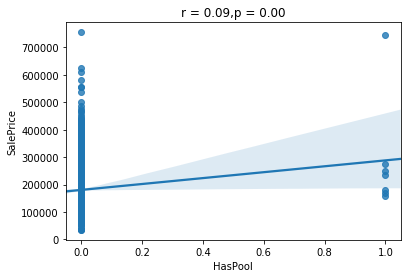

In [41]:
train_data_cc["HasPool"] = 1
train_data_cc.loc[(train_data_cc["PoolArea"].isin([0])), "HasPool"] = 0
test_data_cc["HasPool"] = 1
test_data_cc.loc[(test_data_cc["PoolArea"].isin([0])), "HasPool"] = 0

print_important_info_numeric(train_data_cc, "HasPool", label)

The newly made category doesnt seem any better than the original category, so I will drop both of them

In [42]:
train_data_cc.drop(["HasPool","PoolArea"], axis = 1, inplace = True)
test_data_cc.drop(["HasPool","PoolArea"], axis = 1, inplace = True)

### 1.3.1 Feature extraction

First I print the correlation matrix again, for the updated data set as it is now:


In [43]:
#plot_corr_matrix(train_data_cc, label, "corr_matrix_beforeextraction.png")

In [44]:
print(sorted(list(test_data_cc.columns)))

['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtCondBin', 'BsmtExposureBin', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1Bin', 'BsmtFinType2Bin', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQualBin', 'BsmtUnfSF', 'CentralAirBin', 'ElectricalBin', 'EnclosedPorch', 'ExterQualBin', 'Exterior1stBin', 'Exterior2ndBin', 'FenceBin', 'FireplaceQuBin', 'Fireplaces', 'FoundationBin', 'FullBath', 'GarageArea', 'GarageCars', 'GarageFinishBin', 'GarageQualBin', 'GarageTypeBin', 'GrLivArea', 'HalfBath', 'HeatingQCBin', 'HouseStyleBin', 'HowOld', 'KitchenAbvGr', 'KitchenQualBin', 'LotArea', 'LotFrontage', 'LotShapeBin', 'MSSubClassBin', 'MSZoningBin', 'MasVnrArea', 'MasVnrTypeBin', 'MiscVal', 'NeighborhoodBin', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDriveBin', 'RoofStyleBin', 'SaleConditionBin', 'SaleTypeBin', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd']


Information currently present in the set:

#### 1) Bedroom :

BedroomAbvGr - Number of bedrooms

#### 2) Basement :

TotalBsmtSF - The total area of the basement, subcategories:

FinSF1,FinSF2,UnfSF - Ares of Type1 finish, Type2 finish, and unfininshed area

FinType1Bin, FinType2Bin - Ratings of these finish type areas

FullBath, HalfBath -  Number of bathrooms in the basement

CondBin, QualBin, ExposureBin - Data regarding the quality of the basement

#### 3) Kitchen:

KitchenAbvGr and KitchenQualBin - Number of kitchens and their quality

#### 4) Garage:

GarageArea, GarageCars - Area and number of cars

All the rest are quality-related

#### 5) Bathrooms :

FullBath, HalfBath -  Number of bathrooms above the basement

BsmtFullBath and BsmtHalfBath - Bathrooms in the basement

#### 6) Other categories :

1) Porches - Several categories with the porches area,  could be combined into 1 by addition

2) Age - HowOld, YearBuilt and YearRemodAdd

3) Lot - Area, Shape and FrontageArea 

4) Exterior - Quality and Materials


Ideas for new features:

1) Basement :

Type rating * Area

Total Basement Bathrooms = BsmtFullBath + 0.5 * BsmtHalfBath

In [45]:
train_data_cc["BsmtType1Info"] = train_data_cc["BsmtFinSF1"]*train_data_cc["BsmtFinType1Bin"]
test_data_cc["BsmtType1Info"] = test_data_cc["BsmtFinSF1"]*test_data_cc["BsmtFinType1Bin"]

train_data_cc["BsmtType2Info"] = train_data_cc["BsmtFinSF2"]*train_data_cc["BsmtFinType2Bin"]
test_data_cc["BsmtType2Info"] = test_data_cc["BsmtFinSF2"]*test_data_cc["BsmtFinType2Bin"]

train_data_cc["BsmtAllBathrooms"] = train_data_cc["BsmtFullBath"]+(0.5*train_data_cc["BsmtHalfBath"])
test_data_cc["BsmtAllBathrooms"] = test_data_cc["BsmtFullBath"]+(0.5*test_data_cc["BsmtHalfBath"])

2) Bathrooms - Combine to get the number of all the bathrooms in the housing

In [46]:
train_data_cc["AllBaths"] = train_data_cc["FullBath"]+0.5*train_data_cc["HalfBath"]+train_data_cc["BsmtFullBath"]+0.5*train_data_cc["BsmtHalfBath"]
test_data_cc["AllBaths"] = test_data_cc["FullBath"]+0.5*test_data_cc["HalfBath"]+test_data_cc["BsmtFullBath"]+0.5*test_data_cc["BsmtHalfBath"]

3) Porches - Add all the individual porches area to get the whole porch area

In [47]:
train_data_cc["Porches"] = train_data_cc["EnclosedPorch"]+train_data_cc["OpenPorchSF"]+train_data_cc["3SsnPorch"]+train_data_cc["ScreenPorch"]
test_data_cc["Porches"] = test_data_cc["EnclosedPorch"]+test_data_cc["OpenPorchSF"]+test_data_cc["3SsnPorch"]+test_data_cc["ScreenPorch"]

4) Others :

Get the average room size by dividing the total living area by the total number of rooms

Get the number of the "Non-Obligatory rooms", aka the rooms that are not bedrooms or kitchens. The idea is that even if a housing has a lot of rooms, if most of them are bedrooms, it still doesnt say much. Richer people will have more expensive houses with rooms for entertainment, working rooms, etc...

In [48]:
train_data_cc["AverageRoomSize"] = (train_data_cc["GrLivArea"])/(1+train_data_cc["TotRmsAbvGrd"])
test_data_cc["AverageRoomSize"] = (test_data_cc["GrLivArea"])/(1+test_data_cc["TotRmsAbvGrd"])

train_data_cc["NonObligatoryRooms"] = train_data_cc["TotRmsAbvGrd"]-train_data_cc["BedroomAbvGr"]-train_data_cc["KitchenAbvGr"]
test_data_cc["NonObligatoryRooms"] = test_data_cc["TotRmsAbvGrd"]-test_data_cc["BedroomAbvGr"]-test_data_cc["KitchenAbvGr"]

### 1.3.2 Feature selection

Once again, I first plot the new correlation matrix, and based on it, decide which values to drop

In [49]:
#plot_corr_matrix(train_data_cc, label, "corr_matrix_afterextraction.png")

First and most obvious example of features that should be dropped are the features that show a big level of multicollinearity. Multicolinearity can have negative influence on the model, and should be avoided. In case of multicollinear features :

1) The features can be combined into one feature that is even more useful than each of them individually, or

2) The feature with the lower level of corelation can be dropped.

#### Observations :

1) Garage Cars and Garage Area are very correlated - I need to decide which one to drop. I will check if Garage Area can be transformed in some way so that it correlation to the target is greater than that one of GarageCars. If so, drop Garage Cars. If not, drop Garage Area.

2) Drop YearBuilt, as its correlation is slightly lower than HowOld, and the level of multicolinearity between the two is very large (1 !!!).

3) Drop TotRmsAbvGrd - It has high level of multicollinearity with both GrLivArea and NonObligatoryRooms, which both have higher level od corealtion to the target.

4) BsmtFinSF1 - Will be dropped due to hig level of multicollinearity with BsmtType1Info.

5) Drop SaleConditionBin - Less correlation than SaleTypeBin.

6) Exterior2ndBin - Less corelation than Exterior1stBin, I will combine the 2 into 1 feature and see if i get a better feature. If so, the better feature will be kept and the 2 original will be dropped. If not, Exterior2ndBin will be dropped.

7) BsmtAllBathrooms - High level of multicolinearity with the BsmtFullBath. I will drop it.

8) BsmtType2Info - high multicolinearity with BsmtFinSF2.

Potential candidates for dropping :

1stFlrSF - correlated to TotalBsmtSF. Even though the level of multicolinearity is high, the information that is kept in the two features is different, so I will keep it for now.

Fireplaces - correlated to FireplaceQuBin. Could be combined into one feature. 

HouseStyleBin - correlated to 2ndFlrSF, but the information is different, so I will keep it.

First, I will check the data distribution of the GarageArea feature, to see whether normalizing the data can help with the corelation

0.1797959420587727
0.9098227950882034


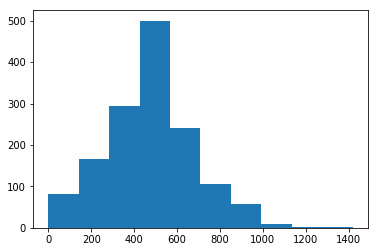

In [50]:
from scipy.stats import kurtosis
from scipy.stats import skew

plt.hist(train_data_cc["GarageArea"])
print(skew(train_data_cc["GarageArea"]))
print(kurtosis(train_data_cc["GarageArea"]))

I will try using the log1p and see whether it helps

In [51]:
train_data_cc["NormalGarageArea"] = np.log1p(train_data_cc["GarageArea"])
test_data_cc["NormalGarageArea"] = np.log1p(test_data_cc["GarageArea"])
corr = train_data_cc.corr()
corr_abs = corr.abs()
corr_abs = corr_abs[label].sort_values(ascending=False)
print("New feature:",corr_abs["NormalGarageArea"])
print("Old feature:",corr_abs["GarageArea"])

New feature: 0.37159712853729776
Old feature: 0.6234314389183598


New feature is not better, so i will drop it alongside the other features that I have chosen for dropping

In [52]:
cats = ["NormalGarageArea","GarageArea","YearBuilt","SaleConditionBin",
       "TotRmsAbvGrd","BsmtFinSF1","BsmtAllBathrooms","BsmtType2Info"]

train_data_cc.drop(cats, axis = 1, inplace = True)
test_data_cc.drop(cats, axis = 1, inplace = True)

Combine Exterior1st and 2nd into one, and see if it is better

In [53]:
train_data_cc["ExteriorMatAdd"] = train_data_cc["Exterior1stBin"]+train_data_cc["Exterior2ndBin"]
train_data_cc["ExteriorMatMul"] = train_data_cc["Exterior1stBin"]*train_data_cc["Exterior2ndBin"]
corr = train_data_cc.corr()
corr_abs = corr.abs()
corr_abs = corr_abs[label].sort_values(ascending=False)
print("New feature Addition:",corr_abs["ExteriorMatAdd"])
print("New feature Multiplication:",corr_abs["ExteriorMatMul"])
print("Old feature 1st:",corr_abs["Exterior1stBin"])
print("Old feature 2nd:",corr_abs["Exterior2ndBin"])

New feature Addition: 0.3630073320535649
New feature Multiplication: 0.362879905228213
Old feature 1st: 0.3517498092751443
Old feature 2nd: 0.3500191261985337


Features made by adding the two features proves slightly better results, so I will keep that one, and get rid of all the others

In [54]:
test_data_cc["ExteriorMatAdd"] = test_data_cc["Exterior1stBin"]+test_data_cc["Exterior2ndBin"]

cats_train = ["ExteriorMatMul","Exterior1stBin","Exterior2ndBin"]
cats_test = ["Exterior1stBin","Exterior2ndBin"]

train_data_cc.drop(cats_train, axis = 1, inplace = True)
test_data_cc.drop(cats_test, axis = 1, inplace = True)

Last, create a new Fireplaces feature and see if it performs better than any of the original 2

In [55]:
train_data_cc["FireplaceInfoAdd"] = train_data_cc["FireplaceQuBin"]+train_data_cc["Fireplaces"]
train_data_cc["FireplaceInfoMul"] = train_data_cc["FireplaceQuBin"]*train_data_cc["Fireplaces"]
corr = train_data_cc.corr()
corr_abs = corr.abs()
corr_abs = corr_abs[label].sort_values(ascending=False)
print("New feature Addition:",corr_abs["FireplaceInfoAdd"])
print("New feature Multiplication:",corr_abs["FireplaceInfoMul"])
print("Old feature FireplaceQuBin:",corr_abs["FireplaceQuBin"])
print("Old feature Fireplaces:",corr_abs["Fireplaces"])

New feature Addition: 0.527245781431287
New feature Multiplication: 0.5100430093768921
Old feature FireplaceQuBin: 0.526473841026049
Old feature Fireplaces: 0.4669288367515242


Features made by adding the two features proves slightly better results, so I will keep that one, and get rid of all the others

In [56]:
test_data_cc["FireplaceInfoAdd"] = test_data_cc["FireplaceQuBin"]+test_data_cc["Fireplaces"]

cats_train = ["FireplaceInfoMul","FireplaceQuBin","Fireplaces"]
cats_test = ["FireplaceQuBin","Fireplaces"]

train_data_cc.drop(cats_train, axis = 1, inplace = True)
test_data_cc.drop(cats_test, axis = 1, inplace = True)

## 1.4 Dealing with the outliers and checking the *normality* of the data the data 

I will first get rid of the outliers in the data.

In [57]:
#plot_corr_matrix(train_data_cc, label, "corr_matrix_afterselection.png")

In [58]:
corr = train_data_cc.corr()
corr_abs = corr.abs()
corr_abs = corr_abs[label].sort_values(ascending=False)
print(corr_abs[corr_abs > 0.5])

SalePrice             1.000000
OverallQual           0.790982
GrLivArea             0.708624
NeighborhoodBin       0.707793
ExterQualBin          0.682639
BsmtQualBin           0.662138
KitchenQualBin        0.659600
GarageCars            0.640409
AllBaths              0.631731
NonObligatoryRooms    0.631425
AverageRoomSize       0.616235
TotalBsmtSF           0.613581
1stFlrSF              0.605852
FullBath              0.560664
GarageFinishBin       0.549247
FireplaceInfoAdd      0.527246
HowOld                0.523350
YearRemodAdd          0.507101
Name: SalePrice, dtype: float64


I will plot the most important features against the SalePrice and look for outliers that should be excluded from the training data:

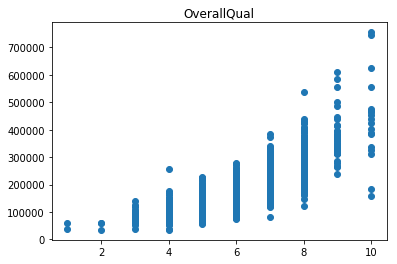

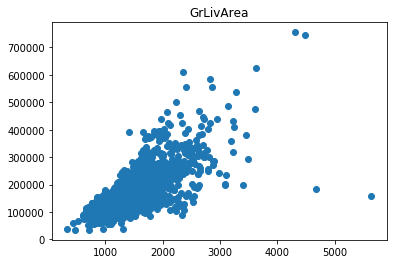

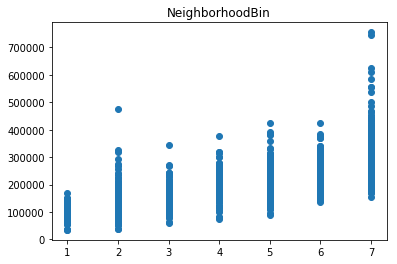

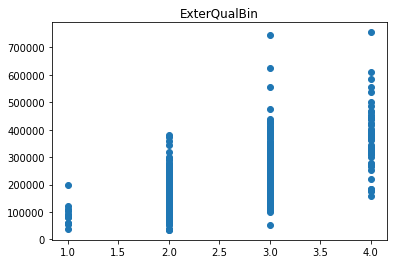

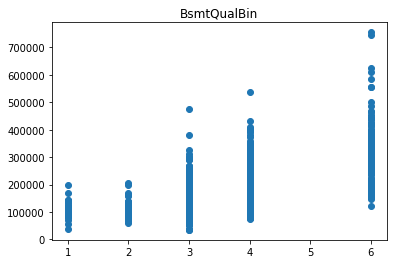

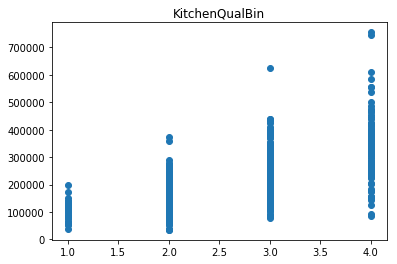

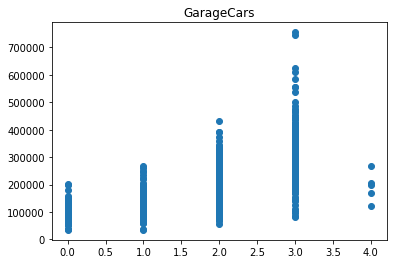

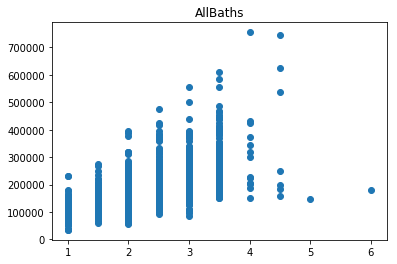

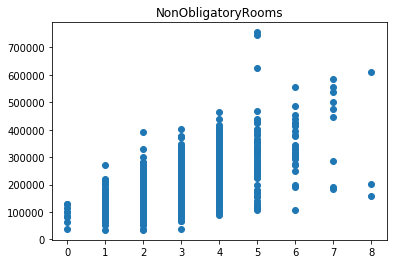

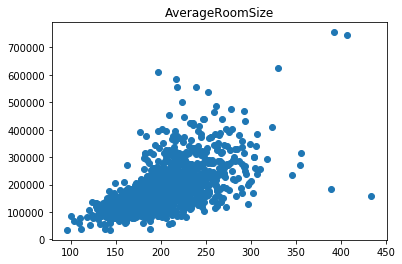

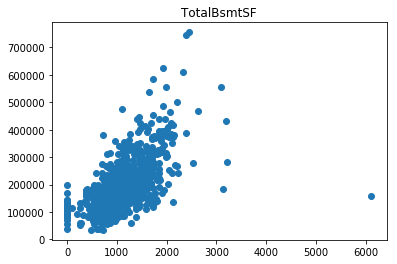

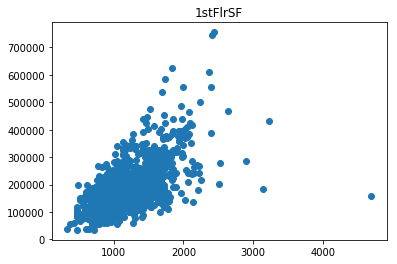

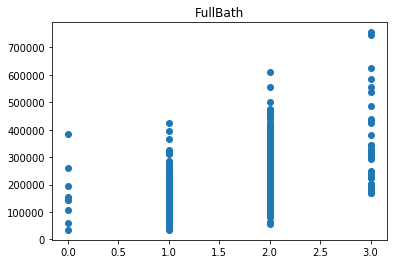

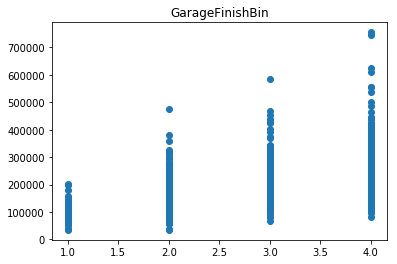

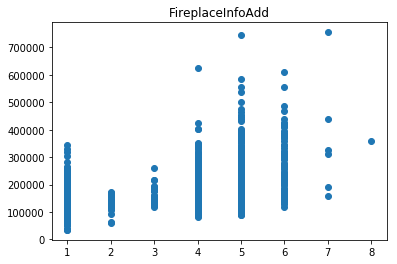

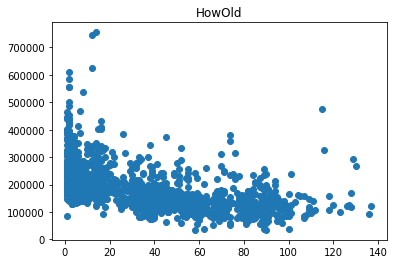

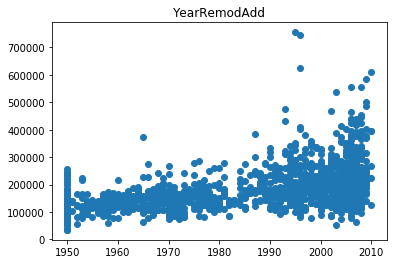

In [59]:
for cat in list(corr_abs[(corr_abs > 0.5) & (corr_abs < 1.0)].index):
    plt.figure()
    plt.title(cat)
    plt.scatter(train_data_cc[cat], train_data_cc['SalePrice'])

Outliers in the training set:

1) OverallQual == 10 and Price < 200000

2) GrLivArea > 4000 and Price < 200000 (Probably the same instances)

3) Average room size > 350 Price < 200000 (Probably the same instances, again)

4) TotalBsmtSF > 4000

5) 1stFlrSF > 4000 (Probably the sam as the one above)


Other observations :

For a couple of the categories, some of the "extreme" values have just a few instances, so they should probably be clipped, for a nicer data distribution.

For now, I start by getting rid of the outliers:

In [60]:
train_data_cc.loc[(train_data_cc["OverallQual"] == 10) & (train_data_cc[label] < 200000)]

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleTypeBin,MSSubClassBin,HowOld,BsmtType1Info,AllBaths,Porches,AverageRoomSize,NonObligatoryRooms,ExteriorMatAdd,FireplaceInfoAdd
523,130.0,40094,10,5,2008,762.0,0,878,3138,3138,...,2,4,1,9040,4.5,406,389.666667,7,6,5
1298,313.0,63887,10,5,2008,796.0,0,466,6110,4692,...,2,4,1,22576,4.5,292,434.000000,8,4,7


In [61]:
train_data_cc.drop([523, 1298], inplace = True)
train_data_cc.loc[(train_data_cc["OverallQual"] == 10) & (train_data_cc[label] < 200000)]

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleTypeBin,MSSubClassBin,HowOld,BsmtType1Info,AllBaths,Porches,AverageRoomSize,NonObligatoryRooms,ExteriorMatAdd,FireplaceInfoAdd


In [62]:
train_data_cc.loc[(train_data_cc["GrLivArea"] > 4000) & (train_data_cc[label] < 200000)]

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleTypeBin,MSSubClassBin,HowOld,BsmtType1Info,AllBaths,Porches,AverageRoomSize,NonObligatoryRooms,ExteriorMatAdd,FireplaceInfoAdd


In [63]:
train_data_cc.loc[(train_data_cc["AverageRoomSize"] > 350) & (train_data_cc[label] < 200000)]

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleTypeBin,MSSubClassBin,HowOld,BsmtType1Info,AllBaths,Porches,AverageRoomSize,NonObligatoryRooms,ExteriorMatAdd,FireplaceInfoAdd


In [64]:
train_data_cc.loc[(train_data_cc["TotalBsmtSF"] > 4000)]

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleTypeBin,MSSubClassBin,HowOld,BsmtType1Info,AllBaths,Porches,AverageRoomSize,NonObligatoryRooms,ExteriorMatAdd,FireplaceInfoAdd


In [65]:
train_data_cc.loc[(train_data_cc["1stFlrSF"] > 4000)]

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleTypeBin,MSSubClassBin,HowOld,BsmtType1Info,AllBaths,Porches,AverageRoomSize,NonObligatoryRooms,ExteriorMatAdd,FireplaceInfoAdd


Got rid of all the outliers, now i start checking the data distribution of all the features, and checking for the normality of the data, starting from the target itself:

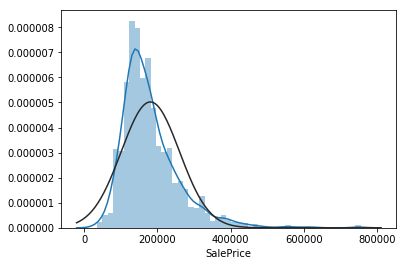

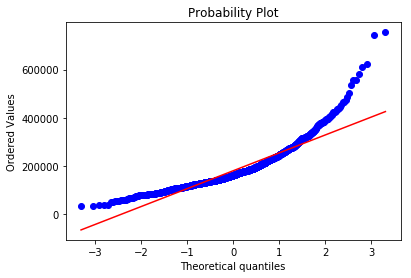

In [66]:
sns.distplot(train_data_cc["SalePrice"], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data_cc["SalePrice"], plot=plt)

The label is not normal, so I will use the log transformation.

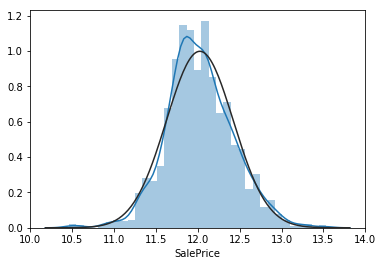

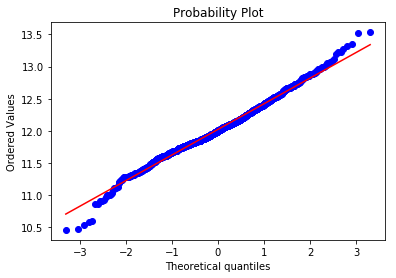

In [67]:
train_data_cc["SalePrice"] = np.log(train_data_cc["SalePrice"])
sns.distplot(train_data_cc["SalePrice"], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data_cc["SalePrice"], plot=plt)

Next one is te OverallQual, as it is the most important feature

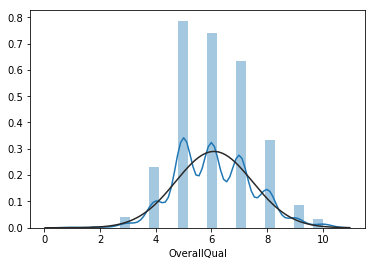

<Figure size 432x288 with 0 Axes>

In [68]:
sns.distplot(train_data_cc["OverallQual"], fit=norm);
fig = plt.figure()

Data is ordinal and it seems like it could be beneficial to do some data clipping, but in order to check it, I will first call the print_important_info_object function to check what is the number of instances belonging to each of the values, and what the median housing price for each of the values is

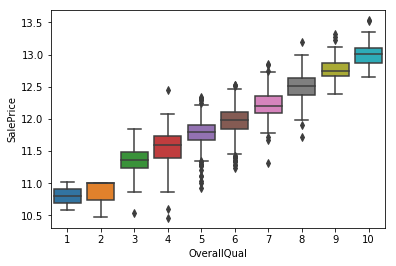

             SalePrice
OverallQual           
10           13.006540
9            12.751300
8            12.505250
7            12.206777
6            11.982929
5            11.798104
4            11.589887
3            11.364900
2            11.002100
1            10.798804
Values inside the training set for OverallQual feature:
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     16
2       3
1       2
Name: OverallQual, dtype: int64
Values inside the test set for OverallQual feature:
5     428
6     357
7     281
8     174
4     110
9      64
3      20
10     13
2      10
1       2
Name: OverallQual, dtype: int64


In [69]:
print_important_info_object(train_data_cc, test_data_cc, "OverallQual", label)

"Extreme" values, like 1, 2 have very few instances in both the training and the test set, so I could group them with 3, in order to make the data more centralized, and then see how the new feature compares to the old one.

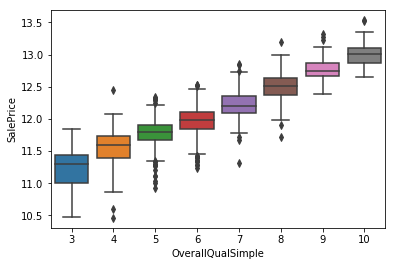

                   SalePrice
OverallQualSimple           
10                 13.006540
9                  12.751300
8                  12.505250
7                  12.206777
6                  11.982929
5                  11.798104
4                  11.589887
3                  11.302204
Values inside the training set for OverallQualSimple feature:
5     397
6     374
7     319
8     168
4     116
9      43
3      25
10     16
Name: OverallQualSimple, dtype: int64
Values inside the test set for OverallQualSimple feature:
5     428
6     357
7     281
8     174
4     110
9      64
3      32
10     13
Name: OverallQualSimple, dtype: int64


In [70]:
train_data_cc["OverallQualSimple"] = train_data_cc["OverallQual"]
test_data_cc["OverallQualSimple"] = test_data_cc["OverallQual"]

train_data_cc.loc[(train_data_cc["OverallQual"].isin([1,2])), "OverallQualSimple"] = 3

test_data_cc.loc[(test_data_cc["OverallQual"].isin([1,2])), "OverallQualSimple"] = 3

print_important_info_object(train_data_cc, test_data_cc, "OverallQualSimple", label)

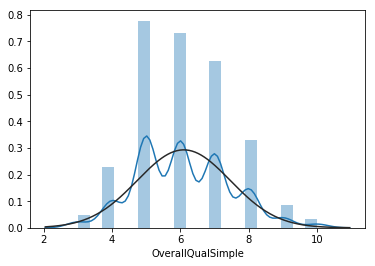

<Figure size 432x288 with 0 Axes>

In [71]:
sns.distplot(train_data_cc["OverallQualSimple"], fit=norm);
fig = plt.figure()

The data is more centralized and has more of a normal distribution, with very few losses of information (only a few instances had the "extreme" values), so I will keep the new feature, and discard the old one!

In [72]:
train_data_cc.drop(["OverallQual"], axis = 1, inplace = True)
test_data_cc.drop(["OverallQual"], axis = 1, inplace = True)

Next one, GrLivArea:

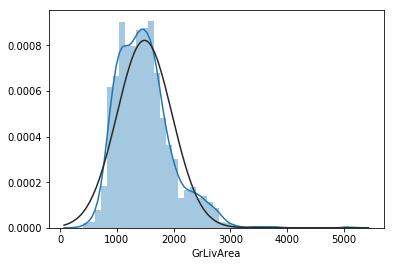

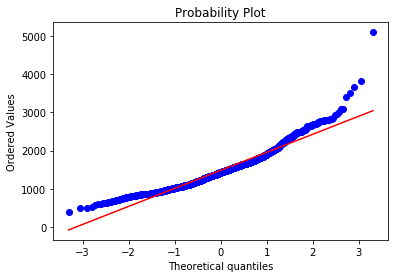

In [73]:
sns.distplot(test_data_cc["GrLivArea"], fit=norm);
fig = plt.figure()
res = stats.probplot(test_data_cc["GrLivArea"], plot=plt)

I will perform the log1p transformation (since the data has high values (in the thousands of SF), adding 1 doesn#t change the data, but makes sure that the transformation is valid even in the case)

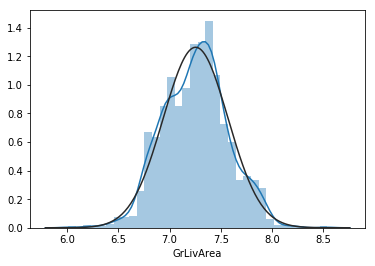

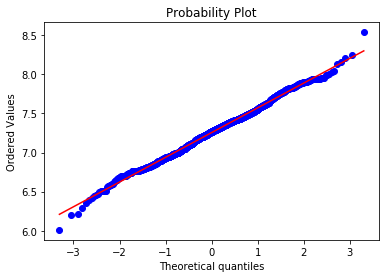

In [74]:
train_data_cc["GrLivArea"] = np.log1p(train_data_cc["GrLivArea"])
test_data_cc["GrLivArea"] = np.log1p(test_data_cc["GrLivArea"])
sns.distplot(test_data_cc["GrLivArea"], fit=norm);
fig = plt.figure()
res = stats.probplot(test_data_cc["GrLivArea"], plot=plt)

Checking other important features:

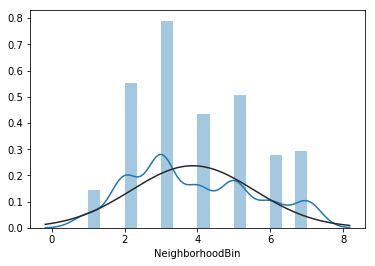

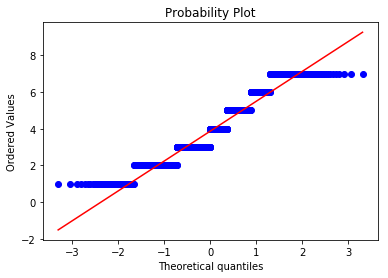

In [75]:
sns.distplot(train_data_cc["NeighborhoodBin"], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data_cc["NeighborhoodBin"], plot=plt)

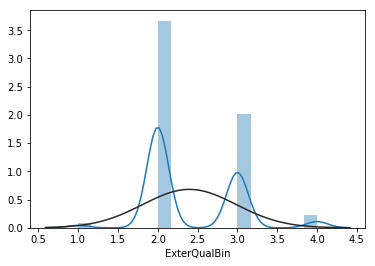

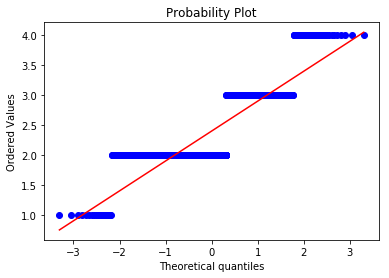

In [76]:
sns.distplot(test_data_cc["ExterQualBin"], fit=norm);
fig = plt.figure()
res = stats.probplot(test_data_cc["ExterQualBin"], plot=plt)

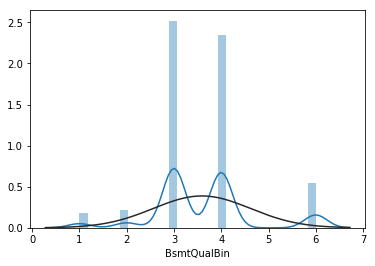

<Figure size 432x288 with 0 Axes>

In [77]:
sns.distplot(test_data_cc["BsmtQualBin"], fit=norm);
fig = plt.figure()

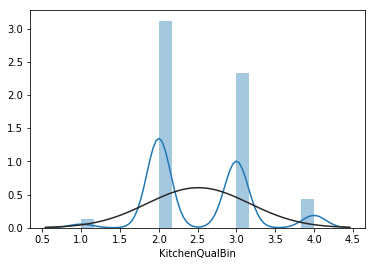

<Figure size 432x288 with 0 Axes>

In [78]:
sns.distplot(test_data_cc["KitchenQualBin"], fit=norm);
fig = plt.figure()

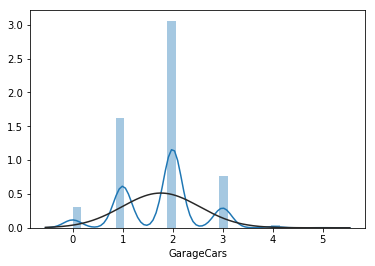

<Figure size 432x288 with 0 Axes>

In [79]:
sns.distplot(test_data_cc["GarageCars"], fit=norm);
fig = plt.figure()

GarageCars might need some transformation to centralize the data:

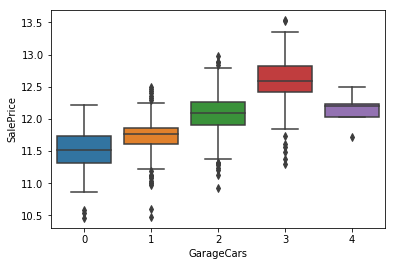

            SalePrice
GarageCars           
3           12.595566
4           12.206073
2           12.089539
1           11.759786
0           11.512925
Values inside the training set for GarageCars feature:
2    823
1    369
3    180
0     81
4      5
Name: GarageCars, dtype: int64
Values inside the test set for GarageCars feature:
2.0    770
1.0    407
3.0    193
0.0     77
4.0     11
5.0      1
Name: GarageCars, dtype: int64


In [80]:
print_important_info_object(train_data_cc, test_data_cc, "GarageCars", label)

Garage cars with values 4 and 5 can be merged into 3, due to the low number of instances in the training and the test set

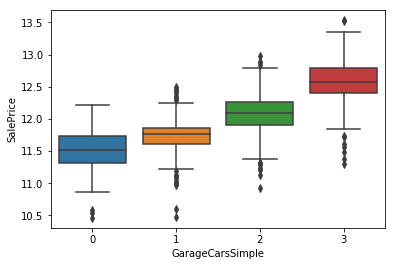

                  SalePrice
GarageCarsSimple           
3                 12.577636
2                 12.089539
1                 11.759786
0                 11.512925
Values inside the training set for GarageCarsSimple feature:
2    823
1    369
3    185
0     81
Name: GarageCarsSimple, dtype: int64
Values inside the test set for GarageCarsSimple feature:
2.0    770
1.0    407
3.0    205
0.0     77
Name: GarageCarsSimple, dtype: int64


In [81]:
train_data_cc["GarageCarsSimple"] = train_data_cc["GarageCars"]
test_data_cc["GarageCarsSimple"] = test_data_cc["GarageCars"]

train_data_cc.loc[(train_data_cc["GarageCars"].isin([4, 5])), "GarageCarsSimple"] = 3
test_data_cc.loc[(test_data_cc["GarageCars"].isin([4, 5])), "GarageCarsSimple"] = 3

print_important_info_object(train_data_cc, test_data_cc, "GarageCarsSimple", label)

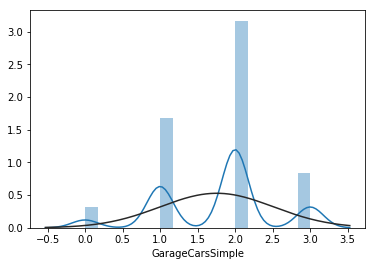

<Figure size 432x288 with 0 Axes>

In [82]:
sns.distplot(test_data_cc["GarageCarsSimple"], fit=norm);
fig = plt.figure()

Data distribution looks better now

In [83]:
train_data_cc.drop(["GarageCars"], axis = 1, inplace = True)
test_data_cc.drop(["GarageCars"], axis = 1, inplace = True)

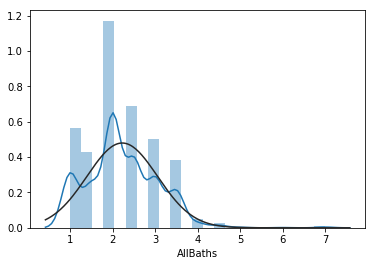

<Figure size 432x288 with 0 Axes>

In [84]:
sns.distplot(test_data_cc["AllBaths"], fit=norm);
fig = plt.figure()

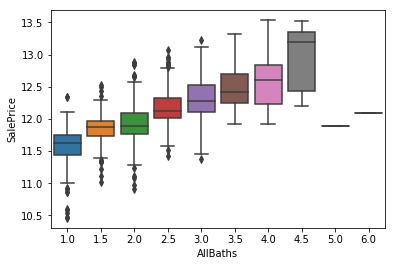

          SalePrice
AllBaths           
4.5       13.195614
4.0       12.610871
3.5       12.417070
3.0       12.272562
2.5       12.122691
6.0       12.095141
5.0       11.890677
2.0       11.884489
1.5       11.867097
1.0       11.628481
Values inside the training set for AllBaths feature:
2.0    456
2.5    295
1.0    228
3.0    186
3.5    144
1.5    129
4.0     13
4.5      5
5.0      1
6.0      1
Name: AllBaths, dtype: int64
Values inside the test set for AllBaths feature:
2.0    446
2.5    263
1.0    215
3.0    192
1.5    164
3.5    145
4.0     18
4.5     10
7.0      3
5.0      2
6.0      1
Name: AllBaths, dtype: int64


In [85]:
print_important_info_object(train_data_cc, test_data_cc, "AllBaths", label)

All the instances with more than 4 bathrooms can be merged with the value 4, as the number of such instances is low

/home/goracinski/.local/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


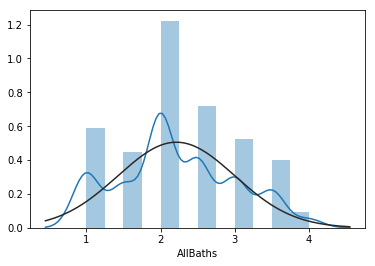

<Figure size 432x288 with 0 Axes>

In [86]:
train_data_cc["AllBaths"].loc[train_data_cc["AllBaths"] > 4.0] = 4.0
test_data_cc["AllBaths"].loc[test_data_cc["AllBaths"] > 4.0] = 4.0

sns.distplot(test_data_cc["AllBaths"], fit=norm);
fig = plt.figure()

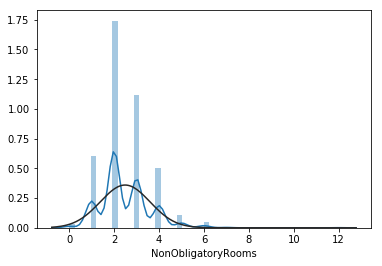

<Figure size 432x288 with 0 Axes>

In [87]:
sns.distplot(test_data_cc["NonObligatoryRooms"], fit=norm);
fig = plt.figure()

Values can be "cropped" at 6 :

/home/goracinski/.local/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


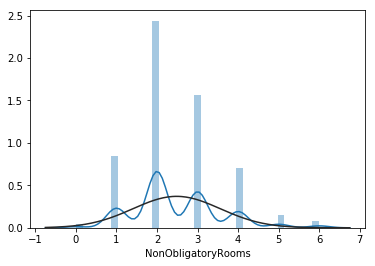

<Figure size 432x288 with 0 Axes>

In [88]:
train_data_cc["NonObligatoryRooms"].loc[train_data_cc["NonObligatoryRooms"] > 6.0] = 6.0
test_data_cc["NonObligatoryRooms"].loc[test_data_cc["NonObligatoryRooms"] > 6.0] = 6.0

sns.distplot(test_data_cc["NonObligatoryRooms"], fit=norm);
fig = plt.figure()

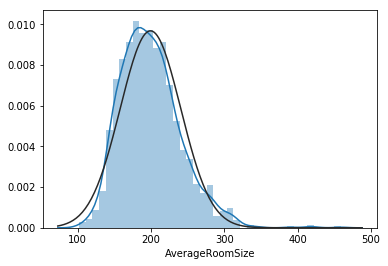

<Figure size 432x288 with 0 Axes>

In [89]:
sns.distplot(test_data_cc["AverageRoomSize"], fit=norm);
fig = plt.figure()

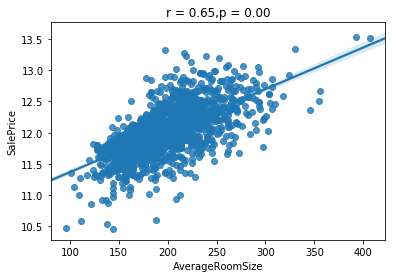

In [90]:
print_important_info_numeric(train_data_cc, "AverageRoomSize", label)

The data seems to be following a trend, and the 2 houses with very high values for the average room size also have higher prices than the rest of the data, so I wont do any clipping. 

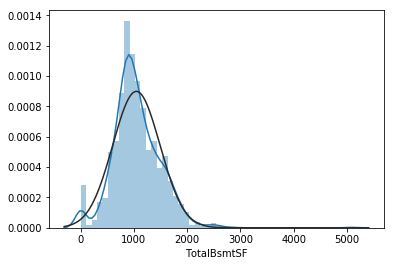

<Figure size 432x288 with 0 Axes>

In [91]:
sns.distplot(test_data_cc["TotalBsmtSF"], fit=norm);
fig = plt.figure()

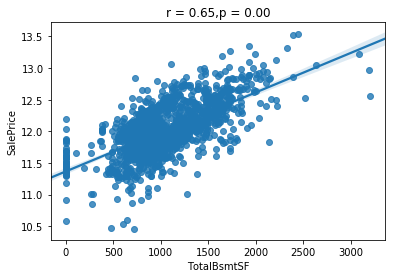

In [92]:
print_important_info_numeric(train_data_cc,"TotalBsmtSF", label)

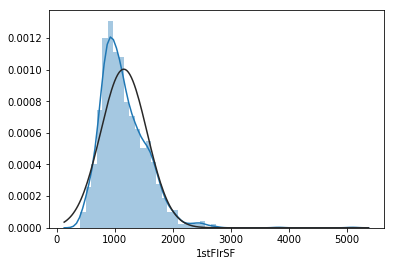

<Figure size 432x288 with 0 Axes>

In [93]:
sns.distplot(test_data_cc["1stFlrSF"], fit=norm);
fig = plt.figure()

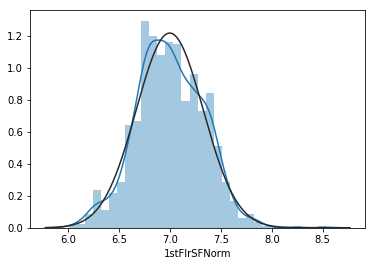

<Figure size 432x288 with 0 Axes>

In [94]:
train_data_cc["1stFlrSFNorm"] = np.log(train_data_cc["1stFlrSF"])
test_data_cc["1stFlrSFNorm"] = np.log(test_data_cc["1stFlrSF"])
sns.distplot(test_data_cc["1stFlrSFNorm"], fit=norm);
fig = plt.figure()

In [95]:
train_data_cc.drop(["1stFlrSF"], axis = 1, inplace = True)
test_data_cc.drop(["1stFlrSF"], axis = 1, inplace = True)

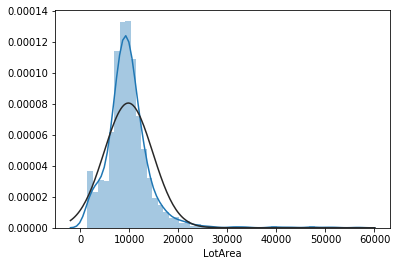

<Figure size 432x288 with 0 Axes>

In [96]:
sns.distplot(test_data_cc["LotArea"], fit=norm);
fig = plt.figure()

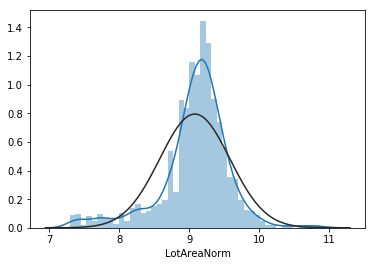

<Figure size 432x288 with 0 Axes>

In [97]:
test_data_cc["LotAreaNorm"] = np.log1p(test_data_cc["LotArea"])
train_data_cc["LotAreaNorm"] = np.log1p(train_data_cc["LotArea"])
sns.distplot(test_data_cc["LotAreaNorm"], fit=norm);
fig = plt.figure()

In [98]:
train_data_cc.drop(["LotArea"], axis = 1, inplace = True)
test_data_cc.drop(["LotArea"], axis = 1, inplace = True)

In [99]:
print(train_data_cc.info())
print(test_data_cc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 58 columns):
LotFrontage           1458 non-null float64
OverallCond           1458 non-null int64
YearRemodAdd          1458 non-null int64
MasVnrArea            1458 non-null float64
BsmtFinSF2            1458 non-null int64
BsmtUnfSF             1458 non-null int64
TotalBsmtSF           1458 non-null int64
2ndFlrSF              1458 non-null int64
GrLivArea             1458 non-null float64
BsmtFullBath          1458 non-null int64
BsmtHalfBath          1458 non-null int64
FullBath              1458 non-null int64
HalfBath              1458 non-null int64
BedroomAbvGr          1458 non-null int64
KitchenAbvGr          1458 non-null int64
WoodDeckSF            1458 non-null int64
OpenPorchSF           1458 non-null int64
EnclosedPorch         1458 non-null int64
3SsnPorch             1458 non-null int64
ScreenPorch           1458 non-null int64
MiscVal               1458 non-null int64
SaleP

In [100]:
#plot_corr_matrix(train_data_cc, label, "corr_matrix_final.png")

Saving the data:

In [101]:
train_data_cc.to_csv("data_stages/train_data_final.csv", index = False)
test_data_cc.to_csv("data_stages/test_data_final.csv", index = False)

In [102]:
train_data_cc = pd.read_csv("data_stages/train_data_final.csv")
test_data_cc = pd.read_csv("data_stages/test_data_final.csv")

This was the last stage of the preprocessing. Compared to the earlier stage, after the feature selection, There is a higher number of highly correlated features, and their correlation to the price is now larger. This data should converge faster, and be better at generalizing, instead of just overfitting the training set.

## 1.5 Train/Validation split

In order for the validation set to provide good approximation of the accuracy of the model, it needs to "mimic" as much as possible the test set. As OverallQualSimple is the feature with the highest correlation to the Price, it will greatly influence the Price (unsurprisingly). Therefore, I will  first check whether the distribution of the test set is similar to that of the training set for that feature, and if so, split the data using the StratifiedKFold, making sure that the distribution of the OverallQualSimple is as similar as possible to the test set.

Since the training set is small, instead of splitting the data once and then using one part for the training and the other for validation, I will perform the StratifiedKFold split 10 times, to get 10 different validation sets. Each of the 10 iterations, it will split the data into 10 parts, where one part is kept as a validation, while the other 9 are kept for training set, all the while making sure that the distribution of the feature inside the validation and training sets are preserved, and that no instances are present in more then 1 validation set. Then, when I train the models, I will train them on all of the training sets individually and check their accuracy on the validation set belonging to that training set. At the end, I will check the average accuracy over all of the validation sets, and use that as a measure of how well the model is performing.

First, I am checking the distribution of the data in the train and the test set:

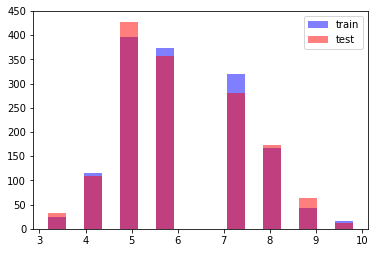

In [103]:
cat = "OverallQualSimple"
max_data = max(train_data_cc[cat].max(), test_data_cc[cat].max())
min_data = min(train_data_cc[cat].min(), test_data_cc[cat].min())
bins = np.linspace(min_data, max_data, 10)
        
plt.hist(train_data_cc[cat], alpha = 0.5, label = "train", color = "blue", bins = bins, align = "mid", rwidth = 0.5)
plt.hist(test_data_cc[cat], alpha = 0.5, label = "test", color = "red", bins = bins, align = "mid", rwidth = 0.5)
plt.legend(loc = "upper right")

Data distribution is fairly similar in the training and the test set, so using it for "mimicking" the test set should be justified.

I will aslo print the indexes present in the validation set, to make sure that there is no overlap between them.

In [104]:
strat_train_data = []
strat_validation_data = []

split = StratifiedKFold(n_splits=10)

for train_index, test_index in split.split(train_data_cc, train_data_cc[cat]):
    print(test_index)
    strat_train_data.append(train_data_cc.loc[train_index])
    strat_validation_data.append(train_data_cc.loc[test_index])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  98 100 101 102 103 104 105 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 137 138 139 141 143 145 147 148 152 153 154 155
 158 160 161 185 250]
[ 97  99 106 121 136 140 142 144 146 149 150 151 156 157 159 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 

In [105]:
print("Distribution of the OverallQualSimple feature:")
print("Distribution over the whole training set:")
print(train_data_cc[cat].value_counts() / len(train_data_cc))
print("Distribution over the whole test set:")
print(test_data_cc[cat].value_counts() / len(test_data_cc))
for i in range(10):    
    print("\n\n", i)
    print(strat_train_data[i][cat].value_counts() / len(strat_train_data[i]))
    print(strat_validation_data[i][cat].value_counts() / len(strat_validation_data[i]))

Distribution of the OverallQualSimple feature:
Distribution over the whole training set:
5     0.272291
6     0.256516
7     0.218793
8     0.115226
4     0.079561
9     0.029492
3     0.017147
10    0.010974
Name: OverallQualSimple, dtype: float64
Distribution over the whole test set:
5     0.293352
6     0.244688
7     0.192598
8     0.119260
4     0.075394
9     0.043866
3     0.021933
10    0.008910
Name: OverallQualSimple, dtype: float64


 0
5     0.272727
6     0.256684
7     0.219251
8     0.115355
4     0.079450
9     0.029030
3     0.016807
10    0.010695
Name: OverallQualSimple, dtype: float64
5     0.268456
6     0.255034
7     0.214765
8     0.114094
4     0.080537
9     0.033557
3     0.020134
10    0.013423
Name: OverallQualSimple, dtype: float64


 1
5     0.272727
6     0.256684
7     0.219251
8     0.115355
4     0.079450
9     0.029030
3     0.016807
10    0.010695
Name: OverallQualSimple, dtype: float64
5     0.268456
6     0.255034
7     0.214765
8     0.114094
4  

As can be seen, in all except for one validation set, the distribution of the OverallQualSimple feature follows the 5 > 6 > 7 > 8 > 4 > 9 > 3 > 10, as is the case in the test set itself. On top of all of that, no test sets are identical, which can be checked: 

In [106]:
for i in range(9):
    for j in range(i+1, 10):
        if strat_train_data[i].equals(strat_train_data[j]):
            print("training sets",i,"and",j,"are equal")
        if strat_validation_data[i].equals(strat_validation_data[j]):
            print("training sets",i,"and",j,"are equal")

Since, by definition of the StratifiedKFold, no validation sets should have the same instances, using 10 different validation sets seems like a good measure of how the model is performing. It will add extra computational cost, but since the data size is small (low number of instances), it shouldn't be too expensive, and in return I will have a good measure of how precise the model is.

## 1.6 Scalling the data:

All the data will be transformed using the StandardScaler. The Scaler will first fit all the data, for the whole data set (merged training (without labels) and test data, to learn the mean and std over the whole data set), and then, using the learned parameters for mean and std, transform all the training and validation sets:


In [107]:
strat_train_labels = []
strat_validation_labels = []

for i in range(10):
    strat_train_labels.append(strat_train_data[i][label].copy()) 
    strat_validation_labels.append(strat_validation_data[i][label].copy()) 
    strat_train_data[i].drop([label], axis = 1, inplace = True)
    strat_validation_data[i].drop([label], axis = 1, inplace = True)

I will also keep the whole training data, with its labels, to be used for training over the whole training set. 

In [108]:
train_labels = train_data_cc[label].copy()
train_data = train_data_cc.drop([label], axis = 1)
test_data = test_data_cc.copy()

In [109]:
colnames = list(train_data.columns)

In [110]:
overall_data = pd.concat([train_data, test_data])
overall_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 57 columns):
LotFrontage           2917 non-null float64
OverallCond           2917 non-null int64
YearRemodAdd          2917 non-null int64
MasVnrArea            2917 non-null float64
BsmtFinSF2            2917 non-null float64
BsmtUnfSF             2917 non-null float64
TotalBsmtSF           2917 non-null float64
2ndFlrSF              2917 non-null int64
GrLivArea             2917 non-null float64
BsmtFullBath          2917 non-null float64
BsmtHalfBath          2917 non-null float64
FullBath              2917 non-null int64
HalfBath              2917 non-null int64
BedroomAbvGr          2917 non-null int64
KitchenAbvGr          2917 non-null int64
WoodDeckSF            2917 non-null int64
OpenPorchSF           2917 non-null int64
EnclosedPorch         2917 non-null int64
3SsnPorch             2917 non-null int64
ScreenPorch           2917 non-null int64
MiscVal               2917 non-null i

Now that I have one set with all of the instances in both the training and the test set, I will fit the parameters of the Standard Scaler (mean and std) on the whole set, and use that scaler to scale all the training, validation and test sets.

In [111]:
scaler = StandardScaler()
scaler.fit(overall_data)
print(scaler.get_params())

{'with_mean': True, 'copy': True, 'with_std': True}


In [112]:
for i in range(10):
    strat_train_data[i] = scaler.transform(strat_train_data[i])
    strat_validation_data[i] = scaler.transform(strat_validation_data[i])
    
train_data = scaler.transform(train_data)    
test_data = scaler.transform(test_data)

# 2 Basic Linear models

## 2.1 Linear Regression

In [113]:
errors_valid = []
errors_train = []

for i in range(10):
    lr = LinearRegression()
    lr.fit(strat_train_data[i], strat_train_labels[i])
    
    predictions = lr.predict(strat_train_data[i])
    errors_train.append(mean_squared_error(strat_train_labels[i], predictions))
    
    predictions = lr.predict(strat_validation_data[i])
    errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

    
print("Training error:")
print("Maximum error:", max(errors_train),"\nMinimum error:", min(errors_train),"\nAverage error:", sum(errors_train)/len(errors_train))
print("Validation error:")
print("Maximum error:", max(errors_valid),"\nMinimum error:", min(errors_valid),"\nAverage error:", sum(errors_valid)/len(errors_valid))

Training error:
Maximum error: 0.012266690177052307 
Minimum error: 0.01141942050136389 
Average error: 0.011914327151022416
Validation error:
Maximum error: 0.0240131660137346 
Minimum error: 0.009244191942520944 
Average error: 0.013392097666129237


(array([672., 581., 153.,  39.,  13.,   0.,   0.,   0.,   0.,   1.]),
 array([  50137.44451576,  151977.59533151,  253817.74614725,
         355657.896963  ,  457498.04777874,  559338.19859448,
         661178.34941023,  763018.50022597,  864858.65104172,
         966698.80185746, 1068538.95267321]),
 <a list of 10 Patch objects>)

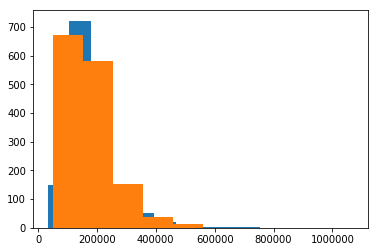

In [114]:
lr.fit(train_data, train_labels)
predictions = lr.predict(test_data)
predictions = np.exp(predictions)
plt.hist(np.exp(train_labels))
plt.hist(predictions)

In [115]:
submission = pd.DataFrame()
submission["Id"] = test_ids
submission["SalePrice"] = predictions
submission.to_csv("submissions/submission_linearreg.csv", index=False)

## 2.2 Ridge Regression

Next model is a Ridge Regression model. It is a regularized model, similar to the linear regression. How it performs regularization is by penalizing steep slopes in the model. If a slope (dependancy of the prediction to a certain feature) is steep, then small variations in the value of that feature can lead to big changes in the prediction, which in turns means high variance. Therefore, Ridge adds the alpha*(slope)^2 term to the function it tries to minimize, which causes it to prefer slopes that have lower values. In a nutshell, it adds bias to the model, making it less likely to overfit the training data.

In [116]:
errors_valid = []
errors_train = []

for i in range(10):
    ridge = Ridge()
    ridge.fit(strat_train_data[i], strat_train_labels[i])
    
    predictions = ridge.predict(strat_train_data[i])
    errors_train.append(mean_squared_error(strat_train_labels[i], predictions))
    
    predictions = ridge.predict(strat_validation_data[i])
    errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

    
print("Training error:")
print("Maximum error:", max(errors_train),"\nMinimum error:", min(errors_train),"\nAverage error:", sum(errors_train)/len(errors_train))
print("Validation error:")
print("Maximum error:", max(errors_valid),"\nMinimum error:", min(errors_valid),"\nAverage error:", sum(errors_valid)/len(errors_valid))

Training error:
Maximum error: 0.012252342520321449 
Minimum error: 0.010987214407667836 
Average error: 0.011849017761223185
Validation error:
Maximum error: 0.02127498617147904 
Minimum error: 0.00927449687738041 
Average error: 0.013131185710122454


In [117]:
hyperparameters_alpha = [30] # chosen 30

valid_err = []
train_err = []


hyperparam = hyperparameters_alpha


param_so_far = []
for parameters in hyperparam: 
    
    errors_valid = []
    errors_train = []
    param_so_far.append(parameters)
    for i in range(10):
        ridge = Ridge(alpha = parameters)
        ridge.fit(strat_train_data[i], strat_train_labels[i])

        predictions = ridge.predict(strat_train_data[i])
        errors_train.append(mean_squared_error(strat_train_labels[i], predictions))

        predictions = ridge.predict(strat_validation_data[i])
        errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

    valid_err.append(sum(errors_valid)/len(errors_valid))
    train_err.append(sum(errors_train)/len(errors_train))
    print(parameters, ":")
    print("Training error:", train_err[len(train_err)-1])
    print("Validation error:", valid_err[len(valid_err)-1])
    print()
   
#plt.plot(hyperparam, train_err, c = "red")
#plt.plot(hyperparam, valid_err, c = "green")

30 :
Training error: 0.011924996705027516
Validation error: 0.013091361946507063



(array([599., 610., 180.,  48.,  19.,   2.,   0.,   0.,   0.,   1.]),
 array([ 50962.2045677 , 144119.23761466, 237276.27066161, 330433.30370857,
        423590.33675552, 516747.36980248, 609904.40284943, 703061.43589639,
        796218.46894334, 889375.5019903 , 982532.53503725]),
 <a list of 10 Patch objects>)

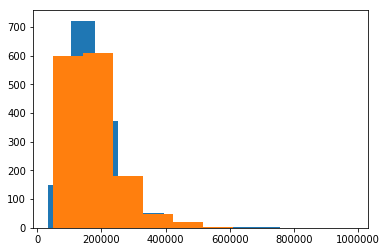

In [118]:
ridge = Ridge(alpha = 30.0)
ridge.fit(train_data, train_labels)
predictions = ridge.predict(test_data)
predictions = np.exp(predictions)
plt.hist(np.exp(train_labels))
plt.hist(predictions)

In [119]:
submission = pd.DataFrame()
submission["Id"] = test_ids
submission["SalePrice"] = predictions
submission.to_csv("submissions/submission_ridgereg.csv", index=False)

## 2.3 Lasso

Lasso uses the same idea as the Ridge Regression, as it is trying to minimize the variance that linear regression might introdice by decreasing the slopes. The difference however, is that Lasso tries to minimize the |slope| (absolute value of the slope), unlike Ridge, that tries to minimize the slope^2 term. What that means in principle, is that Lasso is capable of bringing the slopes all the way down to 0, while Ridge can only reduce them close to a 0 value. That way, Lasso also performs dimensonality reduction, by completely removing features that are of no importance to the model's predictions. 

In conclusion, If the data has a lot of features that are of no use to the model, or could even deteriorate the model's predictions, Lasso will perform better than Ridge, by completely removing these features from the data set. If all the features are of actual use, then Lasso would perform poorer than Ridge, by possibly removing some features that can actually help the predictions.

In [120]:
hyperparameters_alpha = [1.6e-3] # chosen value after the tuning

valid_err = []
train_err = []


hyperparam = hyperparameters_alpha


param_so_far = []
for parameters in hyperparam: 
    
    errors_valid = []
    errors_train = []
    param_so_far.append(parameters)
    for i in range(10):
        lasso = Lasso(alpha = parameters)
        lasso.fit(strat_train_data[i], strat_train_labels[i])

        predictions = lasso.predict(strat_train_data[i])
        errors_train.append(mean_squared_error(strat_train_labels[i], predictions))

        predictions = lasso.predict(strat_validation_data[i])
        errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

    valid_err.append(sum(errors_valid)/len(errors_valid))
    train_err.append(sum(errors_train)/len(errors_train))
    print(parameters, ":")
    print("Training error:", train_err[len(train_err)-1])
    print("Validation error:", valid_err[len(valid_err)-1])
    print()
   
#plt.plot(hyperparam, train_err, c = "red")
#plt.plot(hyperparam, valid_err, c = "green")

0.0016 :
Training error: 0.012012097856111624
Validation error: 0.013038030195421508



(array([653., 586., 161.,  44.,  14.,   0.,   0.,   0.,   0.,   1.]),
 array([  51914.05525537,  149820.1011536 ,  247726.14705183,
         345632.19295005,  443538.23884828,  541444.28474651,
         639350.33064473,  737256.37654296,  835162.42244119,
         933068.46833941, 1030974.51423764]),
 <a list of 10 Patch objects>)

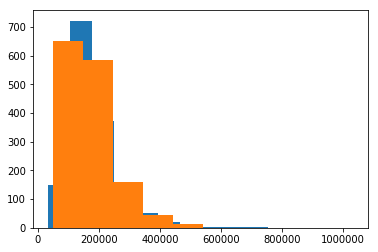

In [121]:
lasso = Lasso(alpha = 1.6e-3)
lasso.fit(train_data, train_labels)
predictions = lasso.predict(test_data)
predictions = np.exp(predictions)
plt.hist(np.exp(train_labels))
plt.hist(predictions)

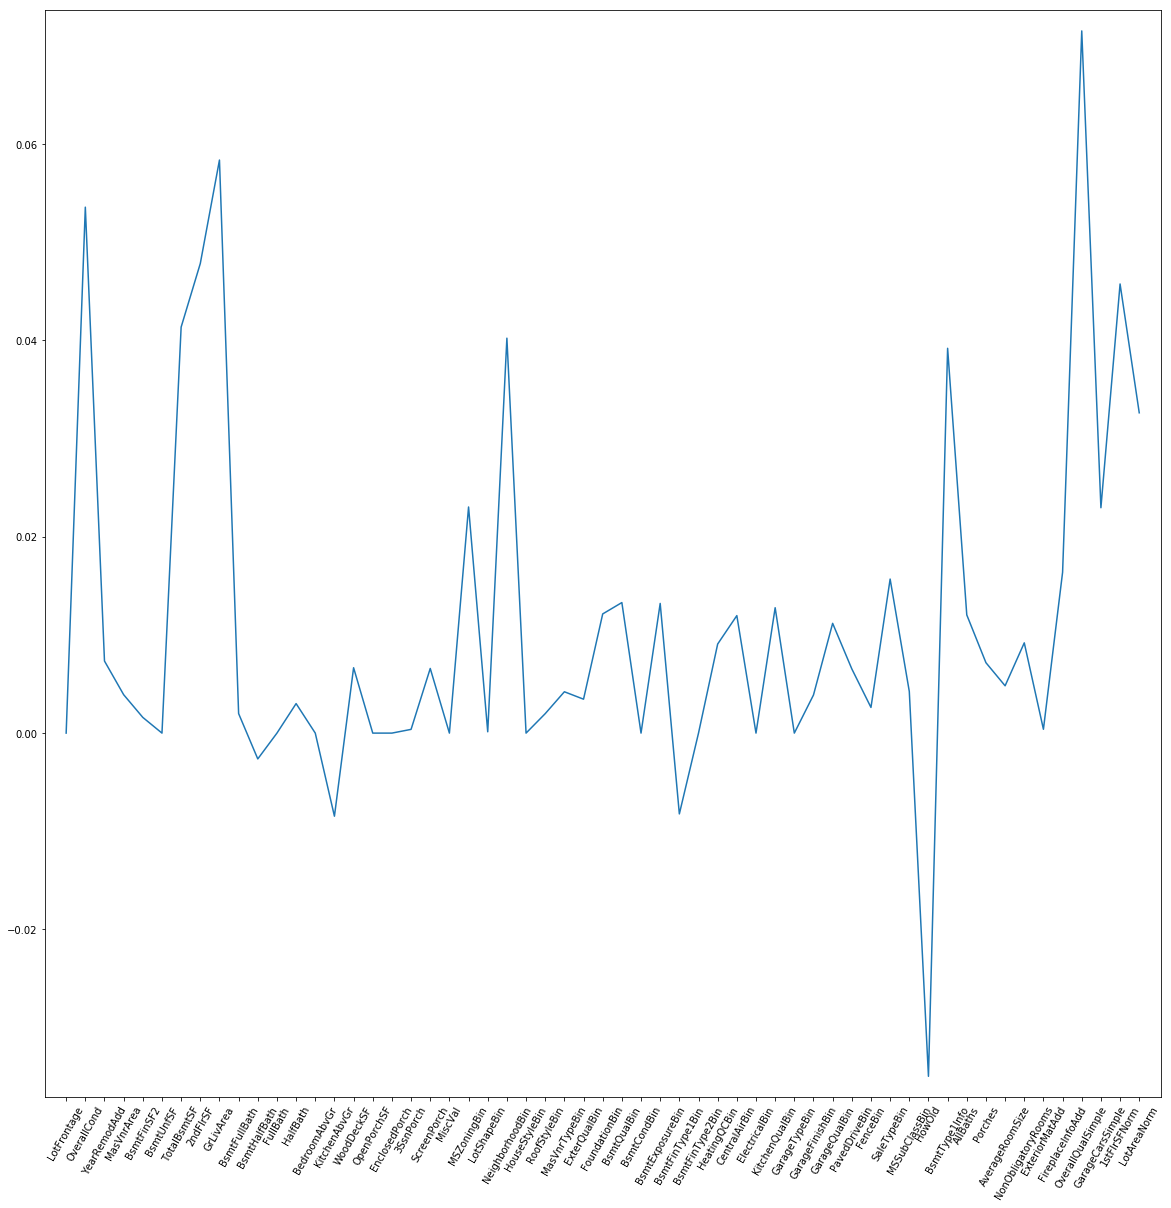

In [122]:
lasso_coef = lasso.coef_
fig = plt.figure(figsize=(20, 20))
plt.plot(range(len(colnames)), lasso_coef)
plt.xticks(range(len(colnames)), colnames, rotation=60) 
plt.margins(0.02)
#plt.show()
plt.savefig("lasso_corr.png")

In [123]:
for member in range(len(colnames)):
    print(colnames[member], lasso_coef[member])

LotFrontage 0.0
OverallCond 0.05356747395036469
YearRemodAdd 0.00733967980558678
MasVnrArea 0.0039132021748450405
BsmtFinSF2 0.0015990223841847746
BsmtUnfSF -0.0
TotalBsmtSF 0.04135223054552461
2ndFlrSF 0.047827887613543535
GrLivArea 0.058365985515803444
BsmtFullBath 0.0019894642851914354
BsmtHalfBath -0.0026293702293207974
FullBath 0.0
HalfBath 0.0030053037985753894
BedroomAbvGr 0.0
KitchenAbvGr -0.00846332074808407
WoodDeckSF 0.0066578380160480875
OpenPorchSF -0.0
EnclosedPorch 0.0
3SsnPorch 0.00038045582843403657
ScreenPorch 0.006584158670746318
MiscVal -0.0
MSZoningBin 0.023029702466507814
LotShapeBin 0.0001338540738221818
NeighborhoodBin 0.04022326020098229
HouseStyleBin -0.0
RoofStyleBin 0.0019805004052270924
MasVnrTypeBin 0.0042107301208206575
ExterQualBin 0.0034544285129378856
FoundationBin 0.012137532778062218
BsmtQualBin 0.01329548612347492
BsmtCondBin -0.0
BsmtExposureBin 0.013207453929168193
BsmtFinType1Bin -0.008230320557690214
BsmtFinType2Bin -0.0
HeatingQCBin 0.009071797

In [124]:
submission = pd.DataFrame()
submission["Id"] = test_ids
submission["SalePrice"] = predictions
submission.to_csv("submissions/submission_lassoreg.csv", index=False)

## 2.4 ElasticNet

ElasticNet uses both the penalty term for Lasso and for Ridge. It is therefore very useful in case we have several highly correlated features (multicolinearity), as Lasso part of the penalty would just choose one of the correlated features randomly, and get rid of all the others (by making the slope 0), whereas the Ridge part would keep all of them, allowing the model to use these features in a better way than each of the two (Lasso and Ridge) individually.

The parameters are tuned by tweaking the alpha and l1_ratio parameters, namely :

l1 (lasso regression alpha parameter) = alpha * l1_ratio and,

l2 = alpha * (1 - l1_ratio)

In [125]:
hyperparameters_alpha = [0.001] # chosen values after tuning
hyperparameters_l1ratio = [0.999]
valid_err = []
train_err = []


hyperparam1 = hyperparameters_alpha
hyperparam2 = hyperparameters_l1ratio


param_so_far = []
for parameters1 in hyperparam1: 
    for parameters2 in hyperparam2: 
    
        errors_valid = []
        errors_train = []
        #param_so_far.append(parameters)
        for i in range(10):
            elnet = ElasticNet(alpha = parameters1, l1_ratio = parameters2)
            elnet.fit(strat_train_data[i], strat_train_labels[i])

            predictions = elnet.predict(strat_train_data[i])
            errors_train.append(mean_squared_error(strat_train_labels[i], predictions))

            predictions = elnet.predict(strat_validation_data[i])
            errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

        valid_err.append(sum(errors_valid)/len(errors_valid))
        train_err.append(sum(errors_train)/len(errors_train))
        print(parameters1, parameters2, ":")
        print("Training error:", train_err[len(train_err)-1])
        print("Validation error:", valid_err[len(valid_err)-1])
        print()
   
#plt.plot(hyperparam, train_err, c = "red")
#plt.plot(hyperparam, valid_err, c = "green")

0.001 0.999 :
Training error: 0.011952482671935197
Validation error: 0.013049635824612152



(array([656., 585., 159.,  44.,  14.,   0.,   0.,   0.,   0.,   1.]),
 array([  51465.36122278,  150001.22803572,  248537.09484867,
         347072.96166161,  445608.82847456,  544144.6952875 ,
         642680.56210044,  741216.42891339,  839752.29572633,
         938288.16253928, 1036824.02935222]),
 <a list of 10 Patch objects>)

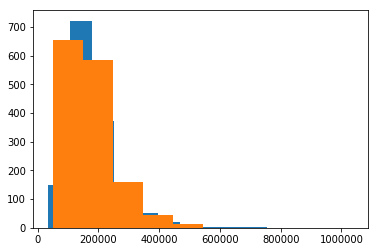

In [126]:
elnet.fit(train_data, train_labels)
predictions = elnet.predict(test_data)
predictions = np.exp(predictions)
plt.hist(np.exp(train_labels))
plt.hist(predictions)

In [127]:
submission = pd.DataFrame()
submission["Id"] = test_ids
submission["SalePrice"] = predictions
submission.to_csv("submissions/submission_elnet.csv", index=False)

The model that I got in the end was basically the same, or at least very similar to the pure Lasso model that I trained in the last step. As l1_ratio had a fairly high value, influence of the ridge regression was minimal, and the majority of regularization came from the lasso regression, that had similar value of alpha as n the last step (0.001, as opposed to 0.0016 in the step before).

# 3 Other models

## 3.1 Support Vector Regression

In [128]:
errors_valid = []
errors_train = []

for i in range(10):
    svr = SVR()
    svr.fit(strat_train_data[i], strat_train_labels[i])
    
    predictions = svr.predict(strat_train_data[i])
    errors_train.append(mean_squared_error(strat_train_labels[i], predictions))
    
    predictions = svr.predict(strat_validation_data[i])
    errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

    
print("Training error:")
print("Maximum error:", max(errors_train),"\nMinimum error:", min(errors_train),"\nAverage error:", sum(errors_train)/len(errors_train))
print("Validation error:")
print("Maximum error:", max(errors_valid),"\nMinimum error:", min(errors_valid),"\nAverage error:", sum(errors_valid)/len(errors_valid))

Training error:
Maximum error: 0.0062490389965369425 
Minimum error: 0.005813694811133357 
Average error: 0.006082610039987243
Validation error:
Maximum error: 0.0396940362148254 
Minimum error: 0.01235840577906879 
Average error: 0.02107021451422468


## 3.2 KNN Regression

In [129]:
errors_valid = []
errors_train = []

for i in range(10):
    knn = KNeighborsRegressor()
    knn.fit(strat_train_data[i], strat_train_labels[i])
    
    predictions = knn.predict(strat_train_data[i])
    errors_train.append(mean_squared_error(strat_train_labels[i], predictions))
    
    predictions = knn.predict(strat_validation_data[i])
    errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

    
print("Training error:")
print("Maximum error:", max(errors_train),"\nMinimum error:", min(errors_train),"\nAverage error:", sum(errors_train)/len(errors_train))
print("Validation error:")
print("Maximum error:", max(errors_valid),"\nMinimum error:", min(errors_valid),"\nAverage error:", sum(errors_valid)/len(errors_valid))

Training error:
Maximum error: 0.018013878053402172 
Minimum error: 0.01605371135214715 
Average error: 0.017372061690216996
Validation error:
Maximum error: 0.036623716244308005 
Minimum error: 0.01827651280038477 
Average error: 0.027044270846797225


## 3.3 Random Forrest Regressor

In [130]:
errors_valid = []
errors_train = []

for i in range(10):
    rf = RandomForestRegressor()
    rf.fit(strat_train_data[i], strat_train_labels[i])
    
    predictions = rf.predict(strat_train_data[i])
    errors_train.append(mean_squared_error(strat_train_labels[i], predictions))
    
    predictions = rf.predict(strat_validation_data[i])
    errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

    
print("Training error:")
print("Maximum error:", max(errors_train),"\nMinimum error:", min(errors_train),"\nAverage error:", sum(errors_train)/len(errors_train))
print("Validation error:")
print("Maximum error:", max(errors_valid),"\nMinimum error:", min(errors_valid),"\nAverage error:", sum(errors_valid)/len(errors_valid))

Training error:
Maximum error: 0.003917527049538793 
Minimum error: 0.0035222008651562223 
Average error: 0.003716278967413152
Validation error:
Maximum error: 0.029071132026205513 
Minimum error: 0.011925026722322391 
Average error: 0.019272088915122262


## 3.4 XGBoost

In [131]:
errors_valid = []
errors_train = []

for i in range(10):
    xb = xgb.XGBRegressor()
    xb.fit(strat_train_data[i], strat_train_labels[i])
    
    predictions = xb.predict(strat_train_data[i])
    errors_train.append(mean_squared_error(strat_train_labels[i], predictions))
    
    predictions = xb.predict(strat_validation_data[i])
    errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

    
print("Training error:")
print("Maximum error:", max(errors_train),"\nMinimum error:", min(errors_train),"\nAverage error:", sum(errors_train)/len(errors_train))
print("Validation error:")
print("Maximum error:", max(errors_valid),"\nMinimum error:", min(errors_valid),"\nAverage error:", sum(errors_valid)/len(errors_valid))

Training error:
Maximum error: 0.007756599833468301 
Minimum error: 0.007010943173863608 
Average error: 0.007512924625421041
Validation error:
Maximum error: 0.023730641315046107 
Minimum error: 0.00962703310652168 
Average error: 0.014335548240391894


XGBoost seems much better than the other models, so I will do some parameter tuning for that model, and check whether a good performance can be reached!

This cell is used for parameter tuning. I will tweak the values of the hyper parameters and see for which combination, the validation error is the lowest. 

In [132]:
hyperparameters_max_depth = [3] # chosen 3
hyperparameters_min_child_weight = range(2,5) # chosen 3
hyperparameters_gamma = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # Chosen 0
hyperparameters_subsample = [i/100.0 for i in range(75,90,5)] # chosen 0.8
hyperparameters_colsample_bytree = [i/100.0 for i in range(75,90,5)] # chosen 0.8
hyperparameters_reg_alpha = [0] # chosen 0

valid_err = []
train_err = []


hyperparam1 = hyperparameters_max_depth
hyperparam2 = hyperparameters_colsample_bytree


param_so_far = []
for parameters1 in hyperparam1: 
    #for parameters2 in hyperparam2: 
    
    errors_valid = []
    errors_train = []
    for i in range(10):
        xb = xgb.XGBRegressor(learning_rate =0.1,
                                 n_estimators=250,
                                 max_depth=parameters1,
                                 min_child_weight=3,
                                 gamma=0,
                                 reg_alpha = 0,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 nthread=-1,
                                 scale_pos_weight=1,
                                 seed=27)
        xb.fit(strat_train_data[i], strat_train_labels[i])

        predictions = xb.predict(strat_train_data[i])
        errors_train.append(mean_squared_error(strat_train_labels[i], predictions))

        predictions = xb.predict(strat_validation_data[i])
        errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

    valid_err.append(sum(errors_valid)/len(errors_valid))
    train_err.append(sum(errors_train)/len(errors_train))
    print(parameters1, ":")
    print("Training error:", train_err[len(train_err)-1])
    print("Validation error:", valid_err[len(valid_err)-1])
    print()



3 :
Training error: 0.00411071735653413
Validation error: 0.013156871208086202



The second cell implements early stopping. I am increasing the number of estimators by a certain number, training such a model, and calculating the validation error. If the validation error has not decreased for some n number of consecutive iterations, I stop the increase in the number of estimators, as future increase in the number of estimators won't increase the overal accuracy of the model.

In [133]:
hyperparameters_nestimators = [540] # chosen after early stopping
valid_err = []
train_err = []
min_val_error = 100.0
counter = 0

hyperparam = hyperparameters_nestimators


param_so_far = []
for parameters in hyperparam: 
    
    errors_valid = []
    errors_train = []
    param_so_far.append(parameters)
    for i in range(10):
        xb = xgb.XGBRegressor(learning_rate =0.05,
                                 n_estimators=parameters,
                                 max_depth=3,
                                 min_child_weight=3,
                                 gamma=0,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 nthread=-1,
                                 scale_pos_weight=1,
                                 seed=27)
        xb.fit(strat_train_data[i], strat_train_labels[i])

        predictions = xb.predict(strat_train_data[i])
        errors_train.append(mean_squared_error(strat_train_labels[i], predictions))

        predictions = xb.predict(strat_validation_data[i])
        errors_valid.append(mean_squared_error(strat_validation_labels[i], predictions))

    valid_err.append(sum(errors_valid)/len(errors_valid))
    train_err.append(sum(errors_train)/len(errors_train))
    print(parameters, ":")
    print("Training error:", train_err[len(train_err)-1])
    print("Validation error:", valid_err[len(valid_err)-1])
    print()
    if valid_err[len(valid_err)-1] < min_val_error:
        min_val_error = valid_err[len(valid_err)-1]
        counter = 0
    else:
        counter += 1
    if counter == 20:
        print("Validation error hasnt decreased for 20 iterations => Early Stopping!")
        print("Best validation error:", valid_err[len(valid_err)-21])
        print("Best n_estimator number:", param_so_far[len(param_so_far)-21])
        break
        
 
#plt.plot(param_so_far, train_err, c = "red")
#plt.plot(param_so_far, valid_err, c = "green")

540 :
Training error: 0.003730106137756161
Validation error: 0.013124331803669972



(array([117., 641., 395., 165.,  74.,  30.,  19.,  12.,   4.,   2.]),
 array([ 39435.484, 100155.516, 160875.55 , 221595.58 , 282315.62 ,
        343035.66 , 403755.7  , 464475.72 , 525195.75 , 585915.75 ,
        646635.8  ], dtype=float32),
 <a list of 10 Patch objects>)

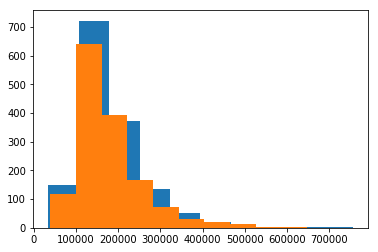

In [134]:
xb = xgb.XGBRegressor(learning_rate =0.05,
                     n_estimators=540,
                     max_depth=3,
                     min_child_weight=3,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     nthread=-1,
                     scale_pos_weight=1,
                     seed=27)

xb.fit(train_data, train_labels)
predictions = xb.predict(test_data)
predictions = np.exp(predictions)
plt.hist(np.exp(train_labels))
plt.hist(predictions)

In [135]:
submission = pd.DataFrame()
submission["Id"] = test_ids
submission["SalePrice"] = predictions
submission.to_csv("submissions/submission_xgboost.csv", index=False)

# Result

As was expected, the best results were achieved by the Linear models, especially Lasso, Ridge and ElasticNet (ElasticNet achieved the highest score of the 3, ranking it on the position 1200/4300 at that moment). None of the other models, even the much more sophisticated XGBoost didnt outperform the 3, which is expected, as the data was meant to be used by linear models.

Lasso also provided insight into which features are very important for the prediction, and which ones could be discarded without any loss in the model performance (by setting their coeficients to 0).